- **Class `Station`**
  - Represents a weather station.
  - **Constructor (`__init__`)**
    - Initializes attributes: station ID (`sid`), latitude, longitude, elevation (`el`), state, name, and various flags (GSN, HCN, WMO) plus country.
  - **String Representation (`__str__`)**
    - Returns a formatted string summarizing the station's ID, name, country, latitude, longitude, and elevation.

- **Class `GHNCD`**
  - Encapsulates methods for processing GHCN Daily data files and associated metadata.
  - **Constructor (`__init__`)**
    - Initializes a list (`station_col_len`) that specifies column lengths for parsing station data.
    - Extends the list by appending two values (5 and 3) repeatedly for 31 iterations.
  - **Method `chunkstring`**
    - Splits a given string into chunks based on a list of lengths.
    - Strips whitespace from each chunk.
  - **Method `processFile`**
    - Reads a file line by line.
    - Uses `chunkstring` to split each line into fields.
    - Extracts:
      - Station ID, year, month, variable field (e.g., TMAX)
      - Associated values and flags.
    - Converts values to integers (using a helper `checkInt`) and replaces missing entries with -9999.
    - Organizes data into a dictionary keyed by variable name (e.g., TMAX, TMIN) with a list of monthly records.
  - **Method `readCountriesFile`**
    - Reads country code data either from a local file or via a URL.
    - Constructs a dictionary mapping two-letter country codes to country names.
    - Prints the total number of countries read.
  - **Method `readStationsFile`**
    - Reads station metadata from a file or URL.
    - Extracts fields: station ID, latitude, longitude, elevation, state, station name, GSN flag, HCN flag, and WMO ID.
    - If `justGSN` is `True`, filters out stations without a valid GSN flag.
    - Creates `Station` objects for each valid station and stores them in a dictionary.
    - Prints the number of stations read.
  - **Method `getVar`**
    - Retrieves data for a specified variable (default 'TMAX') from a station’s dataset.
    - Applies a scaling factor (0.1 for temperatures, 1.0 for snowfall-related variables).
    - Returns a list of tuples, each containing a date and the scaled value.
  - **Method `getTMAX`**
    - Convenience function that returns TMAX values by calling `getVar` with 'TMAX'.
  - **Method `printStation`**
    - Prints the details of a station given its ID.
  - **Method `getStation`**
    - Retrieves and returns a `Station` object from the station dictionary using its ID.
  - **Method `getStatKeyNames`**
    - Returns a list of all station IDs (keys) present in the station dictionary.


In [ ]:
import urllib.request
from datetime import date
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
import os
from datetime import date
from collections import defaultdict
import geopandas as gpd


class Station():
    def __init__(self,sid,lat,lon,el,state,name,gsn,hcn,wmo,country):
        self.sid=sid
        self.lat=lat
        self.lon=lon
        self.el=el
        self.state=state
        self.name=name
        self.gsn=gsn
        self.hcn=hcn
        self.wmo=wmo
        self.country=country

    def __str__(self):
        return self.sid+" is "+self.name+", "+self.country+" at "+str(self.lat)+", "+str(self.lon)+", "+str(self.el)


class GHNCD:


    def __init__(self):
        self.station_col_len = [11,4,2,4]
        for i in range(31):
            self.station_col_len.append(5)
            self.station_col_len.append(3)


    def chunkstring(self,string, lengths):
        return (string[pos:pos+length].strip()
                for idx,length in enumerate(lengths)
                for pos in [sum(map(int, lengths[:idx]))])


    def processFile(self,fileName):
        outDict={}
        with open(fileName, 'r') as fp:
            line = fp.readline()
            while line:
                fields = list(self.chunkstring(line, self.station_col_len))


                station=fields[0]
                year=int(fields[1])
                month=int(fields[2])
                field=fields[3]
                vals=fields[4::2]
                flags=fields[5::2]

                def checkInt(x,flag):
                    if flag=='':
                        return -9999
                    return int(x)


                ivals=[checkInt(x,flag) for (x,flag) in zip(vals,flags)]
                monthDict=dict(year=year,month=month,field=field,vals=ivals,flags=flags)
                if field in outDict.keys():
                    outDict[field]['monthList'].append(monthDict)
                else:
                    fieldDict=dict(monthList=[monthDict])
                    outDict[field]=fieldDict
                line = fp.readline()
        return dict(outDict)

    def readCountriesFile(self,fileName=None):
        self.countryDict={}
        if fileName==None:
            file = urllib.request.urlopen('http://www.hep.ucl.ac.uk/undergrad/0056/other/projects/ghcnd/ghcnd-countries.txt')
        else:
            file = open(fileName,'r')

        for line in file:
            c=str(line[0:2], 'utf-8')
            d=str(line[3:-2], 'utf-8')
            self.countryDict[c]=d
        print("Read",len(self.countryDict),"countries and codes")


    def readStationsFile(self,fileName=None,justGSN=True):

        #------------------------------
        #Variable   Columns   Type
        #------------------------------
        #ID            1-11   Character
        #LATITUDE     13-20   Real
        #LONGITUDE    22-30   Real
        #ELEVATION    32-37   Real
        #STATE        39-40   Character
        #NAME         42-71   Character
        #GSN FLAG     73-75   Character
        #HCN/CRN FLAG 77-79   Character
        #WMO ID       81-85   Character
        #------------------------------
        self.stationDict={}
        if fileName==None:
            file = urllib.request.urlopen('http://www.hep.ucl.ac.uk/undergrad/0056/other/projects/ghcnd/ghcnd-stations.txt')
        else:
            file = open(fileName,'r')

        for line in file:
            sid=str(line[0:11], 'utf-8')
            lat=float(str(line[12:20], 'utf-8'))
            lon=float(str(line[21:30], 'utf-8'))
            el=float(str(line[31:37], 'utf-8'))
            state=str(line[38:40], 'utf-8')
            name=str(line[41:71], 'utf-8')
            gsn=str(line[72:75], 'utf-8')
            hcn=str(line[76:79], 'utf-8')
            wmo=str(line[80:85], 'utf-8')


            if justGSN:
                if gsn=='   ':
                    continue
            self.stationDict[sid]=Station(sid,lat,lon,el,state,name.rstrip(),gsn,hcn,wmo,self.countryDict[sid[0:2]])
        print("Read",len(self.stationDict),"stations with justGSN",justGSN)


    def getVar(self,statDict,varName='TMAX'):

        cal=0.1
        if varName=='SNOW' or varName=='SNWD':
            cal=1.0
        tempList=[ (date(month['year'],month['month'],ind+1),cal*val)  for month in statDict[varName]['monthList'] for ind, val in enumerate(month['vals']) if val!=-9999   ]
        return tempList

    def getTMAX(self,statDict):
        return self.getVar(statDict,'TMAX')

    def printStation(self,sid):
        print(self.stationDict[sid])

    def getStation(self,sid):
        return self.stationDict[sid]

    def getStatKeyNames(self):

        return [*self.stationDict.keys()]

In [ ]:
def list_available_dates_for_station(base_dir, station_id, ghn=None):
    """
    Lists the available years and months for a single station's .dly file
    using the GHNCD class's parsing logic.

    Parameters:
    -----------
    base_dir : str
        Path to the directory containing the station's .dly file.
    station_id : str
        The station ID (filename without '.dly') you want to check.
    ghn : GHNCD, optional
        An instance of the GHNCD class. If not provided, one is created.

    Returns:
    --------
    None
        Prints out the years and months that have data for the given station.
    """


    if ghn is None:
        ghn = GHNCD()


    file_path = os.path.join(base_dir, f"{station_id}.dly")

    if not os.path.isfile(file_path):
        print(f"No .dly file found for station {station_id} in {base_dir}")
        return


    station_data = ghn.processFile(file_path)


    station_dates = set()
    for field_name, field_dict in station_data.items():

        for month_info in field_dict['monthList']:
            year = month_info['year']
            month = month_info['month']
            station_dates.add((year, month))


    if not station_dates:
        print(f"No data entries found in {station_id}.dly")
        return


    sorted_dates = sorted(station_dates)


    year_to_months = defaultdict(list)
    for (y, m) in sorted_dates:
        year_to_months[y].append(m)


    print(f"Station {station_id}:")
    for year in sorted(year_to_months.keys()):
        months = sorted(year_to_months[year])
        print(f"  Year {year}: {', '.join(map(str, months))}")
    print()


- **Parameters**
  - `base_dir`: Directory path containing the station’s .dly file.
  - `station_id`: The station ID (used to construct the filename, without the '.dly' extension).
  - `ghn`: Optional instance of the `GHNCD` class. If not provided, a new instance is created.

- **File Path Construction and Check**
  - Constructs the file path by joining `base_dir` and the filename (`station_id.dly`).
  - Checks if the file exists; if not, prints an error message and returns four empty lists.

- **Data Processing**
  - Calls `ghn.processFile(file_path)` to process the .dly file and obtain the station data as a dictionary.

- **Extracting TMAX Data**
  - Initializes empty lists for TMAX dates and values.
  - If "TMAX" exists in the station data:
    - Retrieves the list of (date, value) pairs using `ghn.getVar(station_data, "TMAX")`.
    - Filters out any values outside the range [-50, 50] Celsius.
    - Separates the filtered data into two lists: one for dates and one for values.

- **Extracting TMIN Data**
  - Similarly initializes empty lists for TMIN dates and values.
  - If "TMIN" exists in the station data:
    - Retrieves the TMIN data using `ghn.getVar(station_data, "TMIN")`.
    - Filters and splits the data into separate lists for dates and values.

- **Return Value**
  - Returns four lists: `tmax_dates`, `tmax_values`, `tmin_dates`, and `tmin_values`.


In [ ]:
def extract_tmax_tmin_for_station(base_dir, station_id, ghn=None):
    """
    Reads the .dly file for a given station, extracts TMAX and TMIN,
    and returns four arrays:
      - tmax_dates, tmax_values
      - tmin_dates, tmin_values

    Parameters
    ----------
    base_dir : str
        Path to the directory containing the station's .dly file.
    station_id : str
        The station ID (filename without '.dly').
    ghn : GHNCD, optional
        An instance of the GHNCD class. If not provided, one is created.

    Returns
    -------
    tmax_dates : list of datetime.date
    tmax_values : list of float
    tmin_dates : list of datetime.date
    tmin_values : list of float

        If no data is found or the file does not exist, all lists will be empty.
        Values outside [-50, 50] Celsius are also discarded.
    """

    if ghn is None:
        ghn = GHNCD()


    file_path = os.path.join(base_dir, f"{station_id}.dly")


    if not os.path.isfile(file_path):
        print(f"No .dly file found for station {station_id} in {base_dir}")
        return [], [], [], []

    station_data = ghn.processFile(file_path)


    tmax_dates = []
    tmax_values = []
    if "TMAX" in station_data:
        tmax_list = ghn.getVar(station_data, "TMAX")

        tmax_filtered = [(dt, val) for (dt, val) in tmax_list if -50 <= val <= 50]
        tmax_dates = [item[0] for item in tmax_filtered]
        tmax_values = [item[1] for item in tmax_filtered]


    tmin_dates = []
    tmin_values = []
    if "TMIN" in station_data:
        tmin_list = ghn.getVar(station_data, "TMIN")

        tmin_filtered = [(dt, val) for (dt, val) in tmin_list if -50 <= val <= 50]
        tmin_dates = [item[0] for item in tmin_filtered]
        tmin_values = [item[1] for item in tmin_filtered]


    return tmax_dates, tmax_values, tmin_dates, tmin_values



- **Function Definition**: `plot_tmax_tmin_arrays` takes TMAX/TMIN dates and values, plus an optional station ID.
- **Subplots Setup**: Creates two vertically stacked subplots (one for TMAX and one for TMIN) sharing the x-axis.
- **TMAX Plot**:
  - If data exists, plots a red scatter plot, adds labels, title, legend, and grid.
  - Formats the x-axis to display years (ticks every 5 years) with rotated labels.
  - If no TMAX data, displays an appropriate title and grid.
- **TMIN Plot**: Mirrors the TMAX plot but uses blue for the scatter plot.
- **Layout and Display**: Adjusts layout with `tight_layout` and then displays the plots.


In [ ]:

def plot_tmax_tmin_arrays(tmax_dates, tmax_values, tmin_dates, tmin_values, station_id="Unknown Station"):
    """
    Plots TMAX and TMIN values on separate subplots against their corresponding dates.
    Both subplots show the year ticks on the x-axis.

    Parameters
    ----------
    tmax_dates : list of datetime.date
        Dates corresponding to TMAX values.
    tmax_values : list of float
        TMAX temperature values in °C.
    tmin_dates : list of datetime.date
        Dates corresponding to TMIN values.
    tmin_values : list of float
        TMIN temperature values in °C.
    station_id : str, optional
        Identifier for the station (used in the subplot titles).
    """

    fig, (ax_tmax, ax_tmin) = plt.subplots(nrows=2, ncols=1, figsize=(12, 8), sharex=True)


    if tmax_dates and tmax_values:
        ax_tmax.scatter(tmax_dates, tmax_values, color='red', s=10, label='TMAX')
        ax_tmax.set_ylabel('Temperature (°C)')
        ax_tmax.set_title(f"TMAX for Station {station_id}")
        ax_tmax.legend()
        ax_tmax.grid(True, linestyle='--', alpha=0.5)
    else:
        ax_tmax.set_title(f"No TMAX data found for Station {station_id}")
        ax_tmax.grid(True, linestyle='--', alpha=0.5)


    ax_tmax.tick_params(axis='x', which='both', labelbottom=True)

    ax_tmax.set_xlabel('Year')
    ax_tmax.xaxis.set_major_locator(mdates.YearLocator(base=5))
    ax_tmax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    plt.setp(ax_tmax.get_xticklabels(), rotation=45)


    if tmin_dates and tmin_values:
        ax_tmin.scatter(tmin_dates, tmin_values, color='blue', s=10, label='TMIN')
        ax_tmin.set_ylabel('Temperature (°C)')
        ax_tmin.set_title(f"TMIN for Station {station_id}")
        ax_tmin.legend()
        ax_tmin.grid(True, linestyle='--', alpha=0.5)
    else:
        ax_tmin.set_title(f"No TMIN data found for Station {station_id}")
        ax_tmin.grid(True, linestyle='--', alpha=0.5)


    ax_tmin.set_xlabel('Year')
    ax_tmin.xaxis.set_major_locator(mdates.YearLocator(base=5))
    ax_tmin.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    plt.setp(ax_tmin.get_xticklabels(), rotation=45)

    plt.tight_layout()
    plt.show()


- **Function Purpose**: Plots monthly average temperatures from a pandas Series.
- **Figure Setup**: Creates a 12x6 inch figure and plots the data as a green scatter plot.
- **Labels & Title**: Sets the x-axis ("Year"), y-axis ("Average Temperature (°C)"), and plot title (including the station ID).
- **Grid & Legend**: Adds a legend and a dashed grid for clarity.
- **X-axis Formatting**: Configures the x-axis to display ticks every 5 years (formatted as '%Y') and rotates tick labels 45°.
- **Layout & Display**: Uses tight layout for spacing and displays the plot.


In [ ]:
def plot_monthly_avg(monthly_avg, station_id="Unknown Station"):
    """
    Plots the monthly average temperature.

    Parameters:
    -----------
    monthly_avg : pandas.Series
        A pandas Series with DateTimeIndex containing the monthly average temperatures.
    station_id : str, optional
        Identifier for the station (used in the plot title).
    """
    plt.figure(figsize=(12, 6))
    plt.scatter(monthly_avg.index, monthly_avg.values, s=10, color='green', label='Monthly Average Temp')
    plt.xlabel("Year")
    plt.ylabel("Average Temperature (°C)")
    plt.title(f"Monthly Average Temperature for Station {station_id}")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)


    plt.gca().xaxis.set_major_locator(mdates.YearLocator(base=5))
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()


- **Function Overview**: Plots training and validation loss from a Keras model's history.
- **Inputs**:
  - `history`: The training history returned by the model's `fit` method.
  - `model_name`: Name of the model (used in the title).
- **Plot Setup**:
  - Creates a 10x6 inch figure and axis.
- **Plotting Data**:
  - Plots training loss (with circle markers).
  - Plots validation loss (with x markers), if available.
- **Labels & Layout**:
  - Sets title, x-label ("Epoch"), and y-label ("Loss (MSE)").
  - Adds grid and legend.
  - Uses a tight layout and displays the plot.
- **Output**: Returns the figure and axis objects.

In [ ]:
def plot_model_loss(history, model_name="Model"):
    """
    Plots the training and validation loss of a model during the training process.

    Parameters:
    - history (History object): The training history object returned by the model's `fit` function.
    - model_name (str): A string representing the name/title of the model.

    Returns:
    - fig, ax: Matplotlib figure and axis objects.
    """

    fig, ax = plt.subplots(figsize=(10, 6))


    ax.plot(history.history['loss'], marker='o', label='Training Loss')
    if 'val_loss' in history.history:
        ax.plot(history.history['val_loss'], marker='x', label='Validation Loss')


    ax.set_title(f"{model_name} Training Loss", fontsize=14)
    ax.set_xlabel("Epoch", fontsize=12)
    ax.set_ylabel("Loss (MSE)", fontsize=12)

    ax.grid(True, linestyle='--', alpha=0.6)


    ax.legend()

    plt.tight_layout()
    plt.show()

    return fig, ax


- **Generate Predictions**: Uses the trained model to predict test data; obtains an array with shape (samples, horizon).
- **Determine Horizons**: If no specific horizons are provided, it plots all horizons; otherwise, it only plots the specified indices.
- **Create Subplots**: Sets up subplots (one per horizon) with a shared x-axis, adjusting the figure size based on the number of horizons.
- **Plot Data**: For each selected horizon, plots:
  - Predicted values (with 'x' markers and dashed line)
  - True values (with 'o' markers)
- **Customize Plots**: Sets title, axis labels, grid, legend, and applies x-axis limits if provided.
- **Finalize Plot**: Uses tight layout for spacing and displays the figure.
- **Return Output**: Returns the figure and array of axis objects.


In [ ]:
def plot_predictions_by_horizon(model, test_data, test_labels, xlim=None, horizons_to_plot=None):
    """
    Plots each requested horizon separately. That is, for each horizon index in the
    model's multi-month forecast, we plot the predicted vs. true labels across
    all test samples in separate subplots.

    Parameters:
    -----------
    model : Keras or compatible model
        Trained model with a .predict() method.
    test_data : numpy array
        Test set features of shape (samples, timesteps, features).
    test_labels : numpy array
        True target values of shape (samples, horizon).
        For example, horizon=12 for a 12-month ahead forecast.
    xlim : tuple or None, optional
        If provided, should be (xmin, xmax) for the x-axis limit. If None, no limit is set.
    horizons_to_plot : list of int or None, optional
        - If None, all horizons [0..(H-1)] are plotted (where H is the total number of horizons).
        - If a list of horizon indices is provided (e.g., [0, 2, 5]), only those horizons
          are plotted. Indices should be 0-based. For instance, horizon index 0 is "Month 1,"
          index 1 is "Month 2," etc.

    Returns:
    --------
    fig, axs : tuple
        The matplotlib figure and array of axis objects.
    """


    test_predict = model.predict(test_data)
    num_horizons = test_predict.shape[1]


    if horizons_to_plot is None:
        horizons_to_plot = list(range(num_horizons))


    fig, axs = plt.subplots(
        nrows=len(horizons_to_plot),
        ncols=1,
        figsize=(10, 4 * len(horizons_to_plot)),
        sharex=True
    )

    if len(horizons_to_plot) == 1:
        axs = [axs]


    for i, h_idx in enumerate(horizons_to_plot):

        axs[i].plot(
            test_predict[:, h_idx],
            marker='x',
            linestyle='--',
            label=f"Predicted (Month {h_idx + 1})"
        )
        axs[i].plot(
            test_labels[:, h_idx],
            marker='o',
            label=f"True (Month {h_idx + 1})"
        )
        axs[i].set_title(f"Forecast for Month {h_idx + 1}", fontsize=14)
        axs[i].set_xlabel("Sample", fontsize=12)
        axs[i].set_ylabel("Value", fontsize=12)
        axs[i].grid(True, linestyle='--', alpha=0.6)
        axs[i].legend()

        if xlim is not None:
            axs[i].set_xlim(xlim)

    plt.tight_layout()
    plt.show()

    return fig, axs


- Creates an instance of the `GHNCD` class.
- Reads the country data by calling `readCountriesFile()`, which populates the country dictionary.
- Reads the station metadata by calling `readStationsFile()`, filtering for stations with valid GSN flags.


In [ ]:
ghn=GHNCD()
ghn.readCountriesFile()
ghn.readStationsFile()

Read 219 countries and codes
Read 991 stations with justGSN True


- **Retrieve Station IDs**: Calls `getStatKeyNames()` to obtain a list of station IDs.
- **Select a Station**: Chooses the station at index 465 (`whichStat=465`).
- **Construct Filename and URL**:
  - Appends '.dly' to the selected station ID to form the filename.
  - Constructs the URL for the .dly file using the base URL and the filename.
- **Download the File**: Uses `urllib.request.urlretrieve` to download the .dly file from the URL.
- **Process the File**: Parses the downloaded file with `processFile()` to extract the station data.
- **Print Station Details**: Retrieves and prints the station’s information with `getStation()`.


In [ ]:
statNames=ghn.getStatKeyNames()

whichStat= 465
fileName=statNames[whichStat]+'.dly'
urlName='http://www.hep.ucl.ac.uk/undergrad/0056/other/projects/ghcnd/ghcnd_gsn/'+fileName

urllib.request.urlretrieve(urlName,fileName)
statDict=ghn.processFile(fileName)
print(ghn.getStation(statNames[whichStat]))

IT000016134 is MONTE CIMONE, Italy at 44.2, 10.7, 2165.0


- **Define Data Directory**: Sets `base_dir` to the directory containing Italian station data.
- **Select Station**: Specifies the station ID as 'IT000016134'.
- **List Dates**: Calls `list_available_dates_for_station` with the base directory and station ID to list all available dates for that station.


In [ ]:
base_dir = '/content/drive/MyDrive/Italian Station'
station_id = 'IT000016134'
list_available_dates_for_station(base_dir , station_id)

Station IT000016134:
  Year 1951: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12
  Year 1952: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12
  Year 1953: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12
  Year 1954: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12
  Year 1955: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12
  Year 1956: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12
  Year 1957: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12
  Year 1958: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12
  Year 1959: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12
  Year 1960: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12
  Year 1961: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12
  Year 1962: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12
  Year 1963: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12
  Year 1964: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12
  Year 1965: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12
  Year 1966: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12
  Year 1967: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12
  Year 1968: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12
  Year 1969: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12
  Year 197

- Calls `extract_tmax_tmin_for_station` with the specified base directory, station ID, and GHNCD instance (`ghn`).
- Extracts TMAX and TMIN data, returning four lists:
  - `tmax_dates` and `tmax_vals` for TMAX (maximum temperatures)
  - `tmin_dates` and `tmin_vals` for TMIN (minimum temperatures)
- Assigns these lists to corresponding variables for further analysis or plotting.


In [ ]:
tmax_dates, tmax_vals, tmin_dates, tmin_vals = extract_tmax_tmin_for_station(base_dir, station_id, ghn=ghn)

In [ ]:
print(tmax_vals)

[0.4, 0.5, -1.0, 0.4, -0.6000000000000001, 0.4, -0.8, -0.4, 0.2, -0.4, -2.0, -2.0, -3.0, -3.4000000000000004, -3.0, -6.4, -0.2, -0.2, -3.0, 0.6000000000000001, 0.6000000000000001, 0.0, -0.8, -0.2, -1.0, -3.2, -3.0, -1.4000000000000001, -4.2, -4.0, -5.0, -4.800000000000001, -5.0, -2.4000000000000004, -3.0, -3.0, -2.8000000000000003, -2.6, -1.2000000000000002, -1.2000000000000002, -0.8, 0.2, 1.2000000000000002, 0.6000000000000001, -0.4, -2.0, 0.2, -0.4, -1.4000000000000001, -0.4, 3.4000000000000004, -2.0, -4.0, -5.4, -3.6, -3.0, -2.6, -2.2, -5.0, -8.200000000000001, -7.0, -6.6000000000000005, -2.0, -1.0, 0.1, -0.2, 0.2, -0.1, 2.4000000000000004, -2.0, -2.4000000000000004, 0.6000000000000001, 0.4, -1.6, 0.0, 1.8, 2.2, 0.6000000000000001, -1.6, -3.8000000000000003, -5.0, 2.5, 2.0, -5.4, -5.0, -2.4000000000000004, -2.4000000000000004, -2.4000000000000004, -2.2, -2.2, -3.6, -2.2, -1.8, -2.6, -2.0, -0.2, -0.4, -1.8, -2.8000000000000003, 0.2, 0.6000000000000001, -1.0, -3.4000000000000004, -0.5

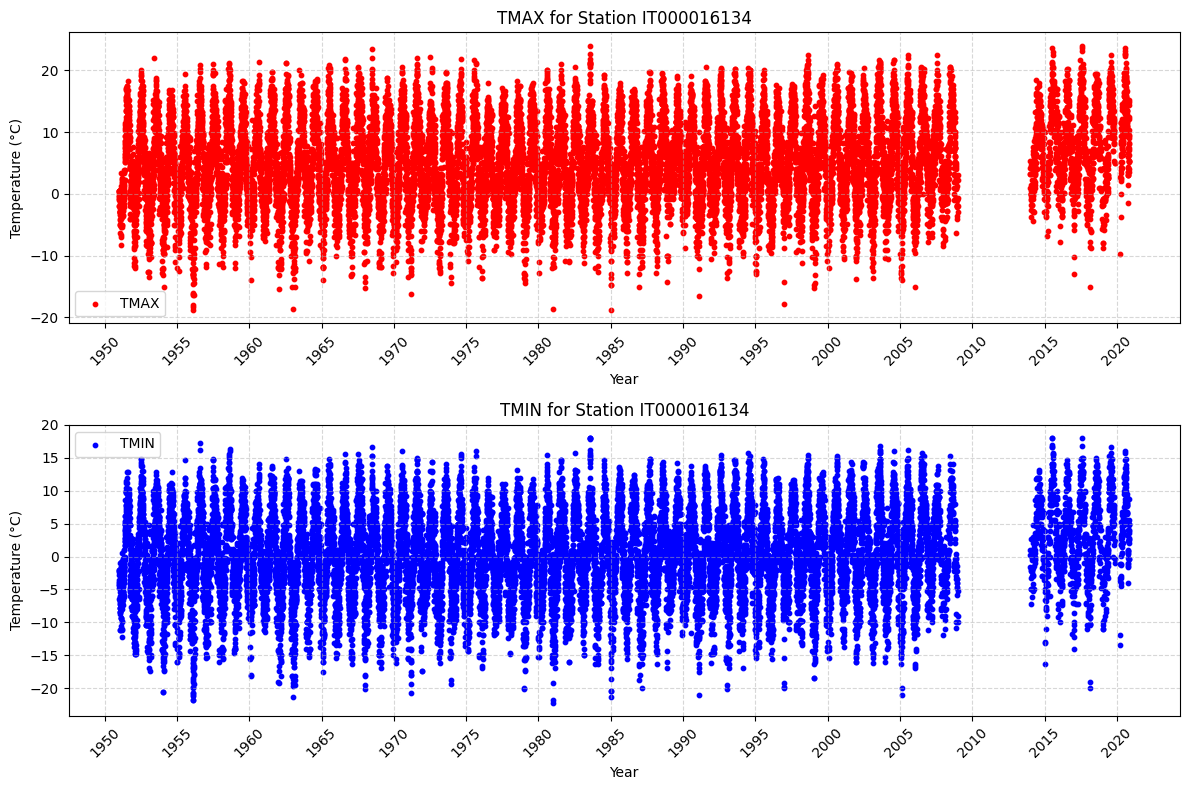

In [ ]:
plot_tmax_tmin_arrays(tmax_dates, tmax_vals, tmin_dates, tmin_vals, station_id)

- **Create DataFrames**:  
  - Constructs `df_tmax` from TMAX dates and values.
  - Constructs `df_tmin` from TMIN dates and values.
- **Merge DataFrames**:  
  - Merges `df_tmax` and `df_tmin` on the "date" column using an inner join.
- **Data Conversion and New Column**:  
  - Converts the "date" column to datetime objects.
  - Computes the average temperature (`avg_temp`) as the mean of TMAX and TMIN.
- **Clean and Resample Data**:  
  - Drops any rows with missing data.
  - Sets the "date" column as the DataFrame index.
  - Resamples the average temperature to a monthly frequency (calculating the mean for each month).
- **Final Steps**:  
  - Converts the monthly average Series to a NumPy array.
  - Prints the first 200 rows of the merged DataFrame.


In [ ]:
df_tmax = pd.DataFrame({'date': tmax_dates, 'tmax': tmax_vals})
df_tmin = pd.DataFrame({'date': tmin_dates, 'tmin': tmin_vals})

df = pd.merge(df_tmax, df_tmin, on='date', how='inner')


df['date'] = pd.to_datetime(df['date'])
df['avg_temp'] = (df['tmax'] + df['tmin']) / 2


df = df.dropna()


df.set_index('date', inplace=True)


monthly_avg = df['avg_temp'].resample('M').mean().dropna()

monthly_avg_array = monthly_avg.to_numpy()

print(df.head(200))

            tmax  tmin  avg_temp
date                            
1951-01-01   0.4  -6.4      -3.0
1951-01-02   0.5  -4.3      -1.9
1951-01-03  -1.0  -2.0      -1.5
1951-01-04   0.4  -2.2      -0.9
1951-01-05  -0.6  -2.4      -1.5
...          ...   ...       ...
1951-07-15  16.4   9.8      13.1
1951-07-16  10.0   7.0       8.5
1951-07-17   6.6   4.8       5.7
1951-07-18  10.2   5.6       7.9
1951-07-19  13.4   8.6      11.0

[200 rows x 3 columns]


<ipython-input-75-bc76819251ab>:18: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_avg = df['avg_temp'].resample('M').mean().dropna()


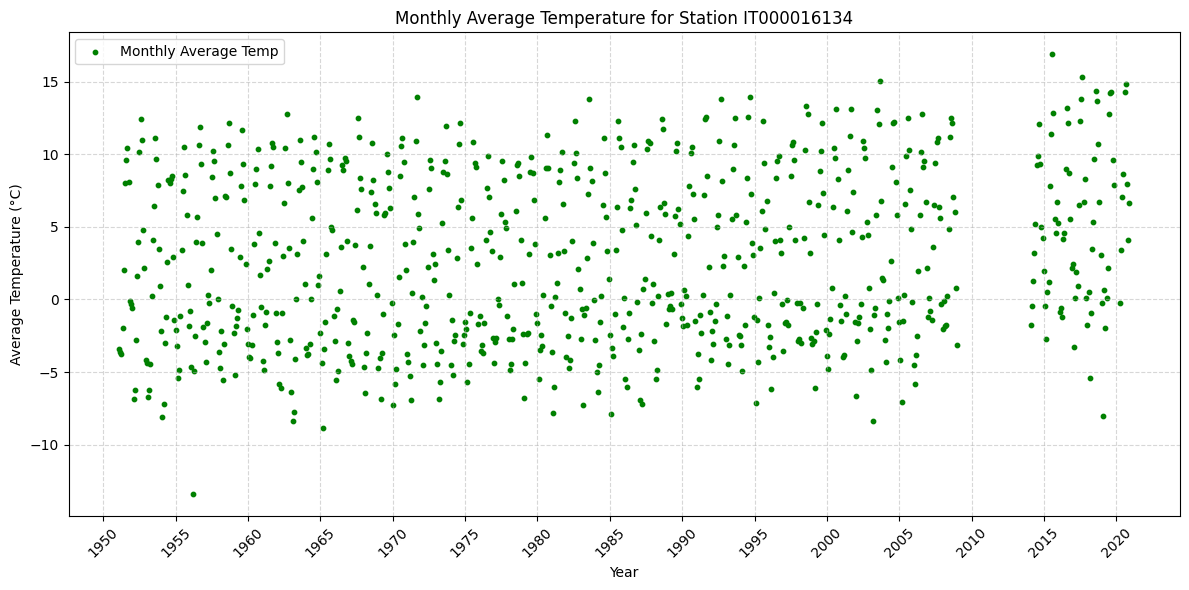

In [ ]:
plot_monthly_avg(monthly_avg, station_id)

---

- **Set Parameters**:  
  - `window_size = 12`: Number of consecutive months used as input features.
  - `forecast_horizon = 12`: Number of months ahead to predict.

- **Initialize Lists**:  
  - Creates empty lists for `features` and `targets`.

- **Sliding Window Loop**:  
  - Iterates over the `monthly_avg` data to create input-output pairs.
  - For each iteration:
    - Extracts a window of 12 months as input (`x`).
    - Extracts the subsequent 12 months as the forecast target (`y`).
  - Appends each `x` to `features` and each `y` to `targets`.

- **Convert to NumPy Arrays**:  
  - Converts `features` and `targets` lists into NumPy arrays for model training.

- **Print Shapes**:  
  - Displays the shapes of the `features` and `targets` arrays to verify the dimensions.


In [ ]:
window_size = 12
forecast_horizon = 12

features = []
targets = []


for i in range(len(monthly_avg) - window_size - forecast_horizon + 1):
    x = monthly_avg.iloc[i:i+window_size].values
    y = monthly_avg.iloc[i+window_size:i+window_size+forecast_horizon].values
    features.append(x)
    targets.append(y)

features = np.array(features)
targets = np.array(targets)

print("Features shape:", features.shape)
print("Targets shape:", targets.shape)

Features shape: (752, 12)
Targets shape: (752, 12)


- **Function Purpose**: Builds an LSTM model with configurable hyperparameters.
- **Parameters**:  
  - `input_timesteps`: Number of time steps in the input sequence.  
  - `output_horizon`: Number of future time steps to predict.  
  - `lstm_units`: Number of LSTM units per layer.  
  - `num_layers`: Number of LSTM layers to stack.  
  - `dropout_rate` and `recurrent_dropout_rate`: Regularization parameters for dropout.  
  - `activation`: Activation function for the LSTM layers.  
  - `optimizer`: Choice of optimizer ('adam', 'rmsprop', or 'sgd').  
  - `learning_rate`: Optional learning rate to override the optimizer default.
- **Model Construction**:
  - Uses a `Sequential` model from Keras.
  - Adds LSTM layers in a loop:
    - The first layer specifies the input shape.
    - Uses `return_sequences` to control output format (last layer does not return sequences).
  - Adds a Dense layer at the end to output predictions for the specified forecast horizon.
- **Optimizer Setup**:
  - If `learning_rate` is provided, configures the chosen optimizer (Adam, RMSprop, or SGD) with that rate.
  - Otherwise, uses the optimizer as given.
- **Compilation**:
  - Compiles the model with Mean Squared Error (MSE) as the loss function.
- **Return Value**:  
  - Returns the compiled LSTM model.


In [ ]:
def build_LSTM_model(
    input_timesteps=12,
    output_horizon=12,
    lstm_units=50,
    num_layers=1,
    dropout_rate=0.0,
    recurrent_dropout_rate=0.0,
    activation='relu',
    optimizer='adam',
    learning_rate=None
):
    """
    Builds an LSTM model with various tunable hyperparameters.
    """


    model = Sequential()


    for i in range(num_layers):

        is_last_layer = (i == num_layers - 1)
        model.add(LSTM(
            lstm_units,
            activation=activation,
            return_sequences=(not is_last_layer),
            dropout=dropout_rate,
            recurrent_dropout=recurrent_dropout_rate,
            input_shape=(input_timesteps, 1) if i == 0 else None
        ))


    model.add(Dense(output_horizon))


    if learning_rate is not None:
        if optimizer == 'adam':
            opt = Adam(learning_rate=learning_rate)
        elif optimizer == 'rmsprop':
            opt = RMSprop(learning_rate=learning_rate)
        elif optimizer == 'sgd':
            opt = SGD(learning_rate=learning_rate)
        else:
            raise ValueError("Unsupported optimizer selected.")
    else:

        opt = optimizer

    model.compile(optimizer=opt, loss='mse')
    return model


- **Train-Test Split**:  
  - Calculates an 80/20 split for the features and targets.
  - Assigns the first 80% of samples to the training set and the remainder to the test set.

- **Model Building**:  
  - Builds an LSTM model with:
    - 12 input time steps and a forecast horizon of 12 months.
    - 128 LSTM units in a single layer.
    - 'relu' activation and 'adam' optimizer (with default learning rate).

- **Early Stopping**:  
  - Sets up an EarlyStopping callback to monitor validation loss, with a patience of 5 epochs and best weights restoration.

- **Model Training**:  
  - Trains the model for up to 100 epochs with a batch size of 16.
  - Uses 20% of the training data as a validation split.
  - Stops training early if validation loss does not improve.

- **Evaluation**:  
  - Evaluates the trained model on the test set.
  - Prints the test mean squared error (MSE) for the LSTM model.


In [ ]:
train_size = int(features.shape[0] * 0.8)
X_train, X_test = features[:train_size], features[train_size:]
y_train, y_test = targets[:train_size], targets[train_size:]


model_LSTM = build_LSTM_model(
    input_timesteps=12,
    output_horizon=12,
    lstm_units=128,
    num_layers=1,
    dropout_rate=0.0,
    recurrent_dropout_rate=0.0,
    activation='relu',
    optimizer='adam',
    learning_rate=None
)


early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history_LSTM = model_LSTM.fit(X_train, y_train, epochs=100, batch_size=16,
                    validation_split=0.2, callbacks=[early_stop], verbose=1)

mse_LSTM = model_LSTM.evaluate(X_test, y_test)
print("LSTM Test Mean Squared Error:", mse_LSTM)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 9s 65ms/step - loss: 32.0790 - val_loss: 15.6316
Epoch 2/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 11.2317 - val_loss: 5.9202
Epoch 3/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 4.8534 - val_loss: 5.3069
Epoch 4/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 4.1014 - val_loss: 4.6566
Epoch 5/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 3.7349 - val_loss: 4.3853
Epoch 6/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 3.5785 - val_loss: 4.2647
Epoch 7/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 3.6312 - val_loss: 4.1522
Epoch 8/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 3.5002 - val_loss: 3.9735
Epoch 9/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 3.4499 - val_loss: 4.0218
Epoch 10/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 3.6231 - val_loss: 4.0888
Epoch 11/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 3.4940 - val_loss: 3.9227
Epoch 12/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/s

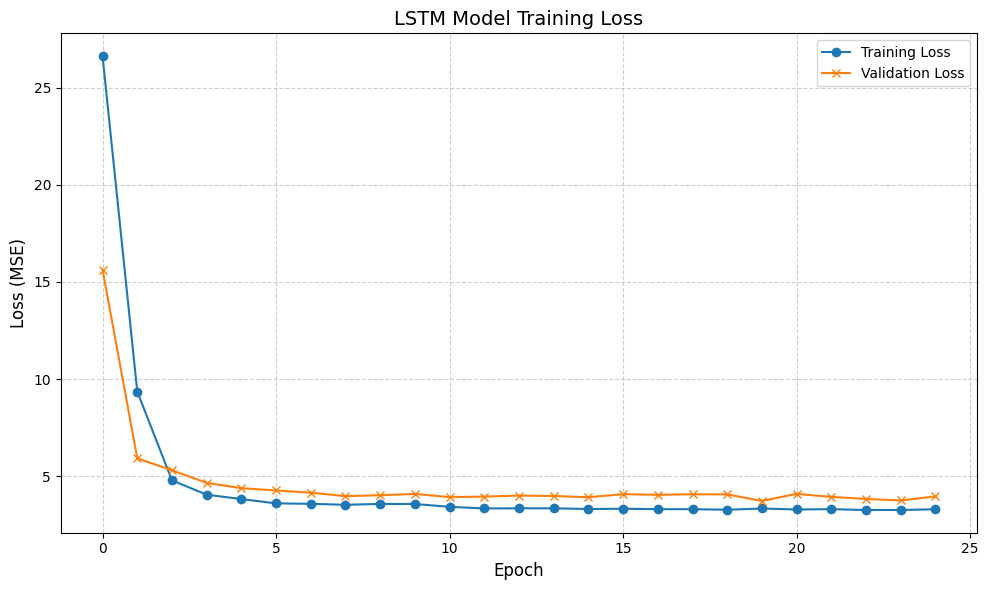

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'LSTM Model Training Loss'}, xlabel='Epoch', ylabel='Loss (MSE)'>)

In [ ]:
plot_model_loss(history_LSTM)

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step


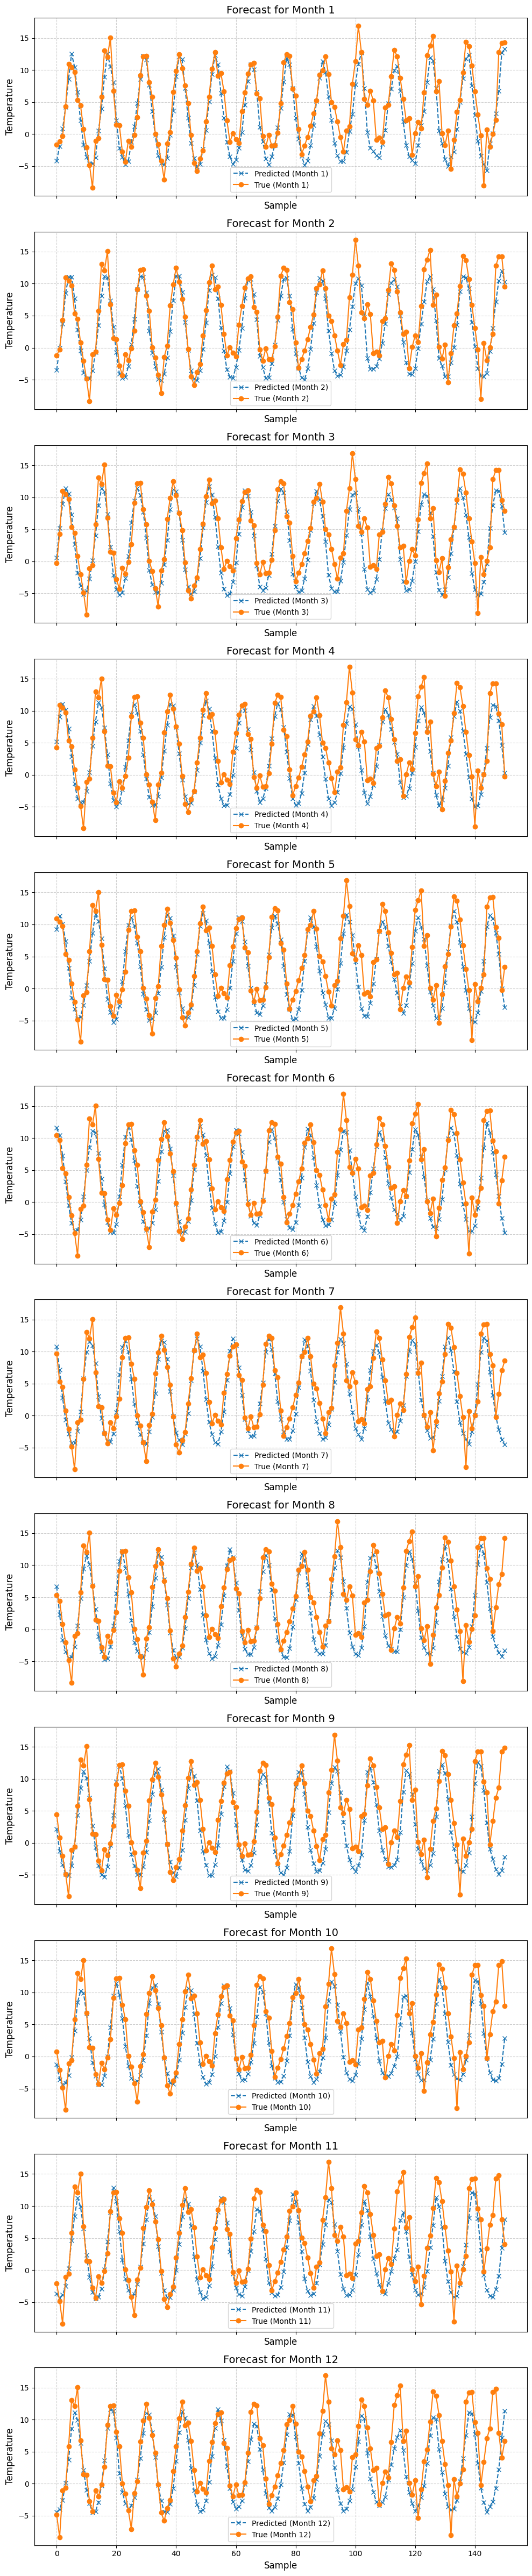

(<Figure size 1000x4800 with 12 Axes>,
 array([<Axes: title={'center': 'Forecast for Month 1'}, xlabel='Sample', ylabel='Temperature'>,
        <Axes: title={'center': 'Forecast for Month 2'}, xlabel='Sample', ylabel='Temperature'>,
        <Axes: title={'center': 'Forecast for Month 3'}, xlabel='Sample', ylabel='Temperature'>,
        <Axes: title={'center': 'Forecast for Month 4'}, xlabel='Sample', ylabel='Temperature'>,
        <Axes: title={'center': 'Forecast for Month 5'}, xlabel='Sample', ylabel='Temperature'>,
        <Axes: title={'center': 'Forecast for Month 6'}, xlabel='Sample', ylabel='Temperature'>,
        <Axes: title={'center': 'Forecast for Month 7'}, xlabel='Sample', ylabel='Temperature'>,
        <Axes: title={'center': 'Forecast for Month 8'}, xlabel='Sample', ylabel='Temperature'>,
        <Axes: title={'center': 'Forecast for Month 9'}, xlabel='Sample', ylabel='Temperature'>,
        <Axes: title={'center': 'Forecast for Month 10'}, xlabel='Sample', ylabel='Tempe

In [ ]:
plot_predictions_by_horizon(model_LSTM, X_test, y_test)

- **Create Baseline Predictions**:  
  - Copies the `features` array into `naive_preds` (i.e., assumes the last observed values persist).

- **Compute Naive MSE**:  
  - Calculates the mean squared error between `naive_preds` and `targets`.

- **Output**:  
  - Prints the computed naive baseline MSE.


In [ ]:
naive_preds = features.copy()

mse_naive = np.mean((naive_preds - targets)**2)
print("Naive Baseline MSE:", mse_naive)

Naive Baseline MSE: 6.441720275381097


- **Set Naive Test Predictions**:  
  - Assigns the test features `X_test` to `naive_preds_test` as the naive prediction.

- **Compute Naive Test MSE**:  
  - Calculates the mean squared error between `naive_preds_test` and the true test targets `y_test`.

- **Print Naive Baseline Test MSE**:  
  - Outputs the computed MSE for the naive baseline.

- **Compare Models**:  
  - Checks if the LSTM model's MSE (`mse_LSTM`) is lower than the naive baseline's MSE.
  - Prints a message indicating whether the ML model outperforms the naive baseline or not.


In [ ]:
naive_preds_test = X_test
mse_naive_test = np.mean((naive_preds_test - y_test)**2)
print("Naive Baseline Test MSE:", mse_naive_test)
if mse_LSTM  < mse_naive_test:
    print("Our ML model beats the naive baseline!")
else:
    print("The naive baseline is better than (or equal to) our LSTM model.")

Naive Baseline Test MSE: 9.598997153217475
The naive baseline is better than (or equal to) our LSTM model.


---

# Testing RNN on the same dataset

- **Function Purpose**: Builds and compiles a multi-layer SimpleRNN model for forecasting.
- **Parameters**:
  - `input_timesteps`: Number of input time steps (default is 12).
  - `output_horizon`: Number of output steps to predict (default is 12).
  - `rnn_units`: Number of units per SimpleRNN layer (default is 50).
  - `num_layers`: Number of SimpleRNN layers to stack (default is 1).
  - `dropout_rate`: Dropout rate for regularization (default is 0.0).
  - `activation`: Activation function for the RNN layers (default is 'relu').
  - `optimizer`: Optimizer to use (default is 'adam').
  - `learning_rate`: Optional learning rate; if provided, it overrides the optimizer's default.
- **Model Construction**:
  - Initializes a Sequential model.
  - Adds the specified number of SimpleRNN layers:
    - The first layer defines the input shape.
    - Uses `return_sequences=True` for all layers except the last.
  - Adds a Dense layer with `output_horizon` units to produce the forecast.
- **Optimizer Configuration & Compilation**:
  - If a learning rate is provided, creates the chosen optimizer (Adam, RMSprop, or SGD) with that learning rate.
  - Otherwise, uses the provided optimizer as-is.
  - Compiles the model with Mean Squared Error (MSE) as the loss.
- **Return**:
  - Returns the compiled Keras SimpleRNN model.


In [ ]:
def build_simple_rnn(
    input_timesteps=12,
    output_horizon=12,
    rnn_units=50,
    num_layers=1,
    dropout_rate=0.0,
    activation='relu',
    optimizer='adam',
    learning_rate=None
):
    """
    Builds a multi-layer SimpleRNN model with various tunable hyperparameters.

    Parameters:
    -----------
    input_timesteps : int
        Number of time steps in each input sample (e.g., 12).
    output_horizon : int
        Number of forecast steps (e.g., 12).
    rnn_units : int
        Number of units (neurons) in each SimpleRNN layer (default=50).
    num_layers : int
        How many SimpleRNN layers to stack (default=1).
    dropout_rate : float
        Dropout rate for each RNN layer (default=0.0).
    activation : str
        Activation function to use in the RNN (e.g., 'relu', 'tanh').
    optimizer : str
        Which optimizer to use ('adam', 'rmsprop', 'sgd') or a Keras optimizer instance.
    learning_rate : float, optional
        Learning rate for the optimizer. If None, uses the optimizer's default.

    Returns:
    --------
    model : tf.keras.Model
        Compiled Keras SimpleRNN model.
    """

    model = Sequential()

    for i in range(num_layers):

        is_last_layer = (i == num_layers - 1)

        model.add(SimpleRNN(
            units=rnn_units,
            activation=activation,
            return_sequences=not is_last_layer,
            dropout=dropout_rate,
            input_shape=(input_timesteps, 1) if i == 0 else None
        ))

    model.add(Dense(output_horizon))

    if learning_rate is not None:
        if optimizer == 'adam':
            opt = Adam(learning_rate=learning_rate)
        elif optimizer == 'rmsprop':
            opt = RMSprop(learning_rate=learning_rate)
        elif optimizer == 'sgd':
            opt = SGD(learning_rate=learning_rate)
        else:
            raise ValueError("Unsupported optimizer selected.")
    else:

        opt = optimizer

    model.compile(optimizer=opt, loss='mse')
    return model

- **Build RNN Model**:  
  - Calls `build_simple_rnn` to create a SimpleRNN model with:
    - 12 input time steps and a 12-month forecast horizon.
    - 128 RNN units in one layer.
    - 'relu' activation and the Adam optimizer.
- **Early Stopping**:  
  - Sets up an EarlyStopping callback monitoring validation loss with a patience of 5 epochs and restoring best weights.
- **Train the Model**:  
  - Trains the RNN on `X_train` and `y_train` for up to 100 epochs with a batch size of 16.
  - Uses 20% of the training data for validation.
  - Verbosity is set to display training progress.

In [ ]:
model_RNN = build_simple_rnn(
    input_timesteps=12,
    output_horizon=12,
    rnn_units=128,
    num_layers=1,
    dropout_rate=0.0,
    activation='relu',
    optimizer='adam',
    learning_rate= None
)

early_stop = EarlyStopping(monitor='val_loss', patience = 5, restore_best_weights=True)

history_RNN = model_RNN.fit(X_train, y_train, epochs=100, batch_size=16,
                    validation_split=0.2, callbacks=[early_stop], verbose=1)

Epoch 1/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 28.9902 - val_loss: 6.4050
Epoch 2/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 4.6469 - val_loss: 4.6150
Epoch 3/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 3.7675 - val_loss: 4.1421
Epoch 4/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.5067 - val_loss: 3.9753
Epoch 5/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 3.6532 - val_loss: 4.2024
Epoch 6/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.7067 - val_loss: 3.9767
Epoch 7/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.4730 - val_loss: 4.0172
Epoch 8/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.4906 - val_loss: 4.1878
Epoch 9/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.4786 - val_loss: 4.4196


- **Evaluate RNN**: Computes the test mean squared error (MSE) on the test data using `model_RNN.evaluate`.
- **Print RNN MSE**: Displays the computed MSE for the RNN model.
- **Compare Models**:  
  - Compares `mse_LSTM` (MSE from the LSTM model) with `mse_RNN`.
  - Prints a message indicating whether the LSTM model outperforms the RNN model or vice versa.


In [ ]:
mse_RNN = model_RNN.evaluate(X_test, y_test)
print("RNN Model MSE:", mse_RNN)
if mse_LSTM < mse_RNN:
    print("LSTM model beats the RNN model!")
else:
    print("The RNN model is better than (or equal) to our LSTM model.")

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 7.8169
RNN Model MSE: 11.201227188110352
LSTM model beats the RNN model!


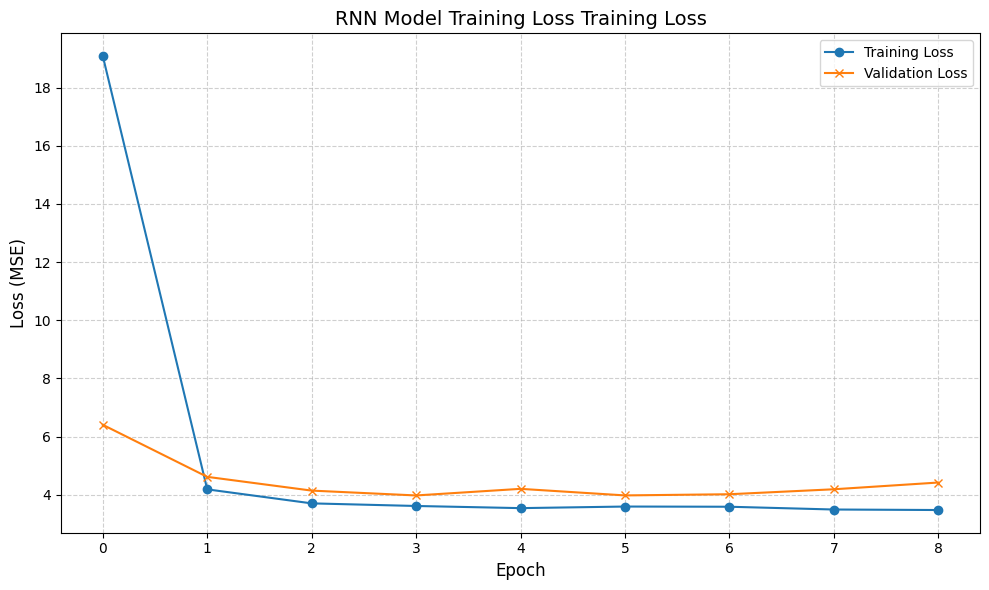

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'RNN Model Training Loss Training Loss'}, xlabel='Epoch', ylabel='Loss (MSE)'>)

In [ ]:
plot_model_loss(history_RNN, model_name= 'RNN Model Training Loss')

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


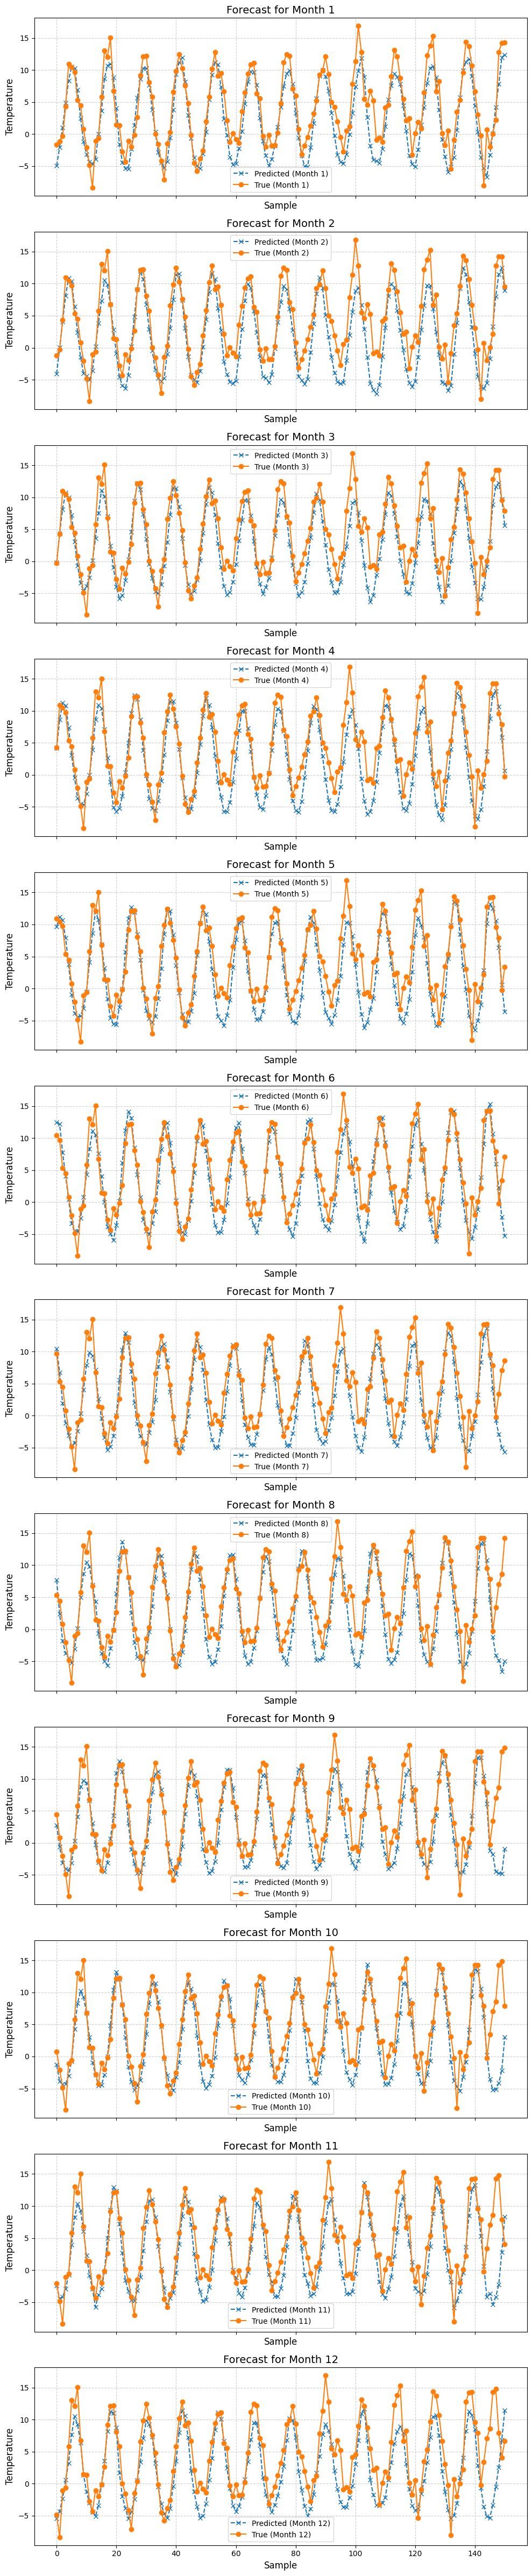

(<Figure size 1000x4800 with 12 Axes>,
 array([<Axes: title={'center': 'Forecast for Month 1'}, xlabel='Sample', ylabel='Temperature'>,
        <Axes: title={'center': 'Forecast for Month 2'}, xlabel='Sample', ylabel='Temperature'>,
        <Axes: title={'center': 'Forecast for Month 3'}, xlabel='Sample', ylabel='Temperature'>,
        <Axes: title={'center': 'Forecast for Month 4'}, xlabel='Sample', ylabel='Temperature'>,
        <Axes: title={'center': 'Forecast for Month 5'}, xlabel='Sample', ylabel='Temperature'>,
        <Axes: title={'center': 'Forecast for Month 6'}, xlabel='Sample', ylabel='Temperature'>,
        <Axes: title={'center': 'Forecast for Month 7'}, xlabel='Sample', ylabel='Temperature'>,
        <Axes: title={'center': 'Forecast for Month 8'}, xlabel='Sample', ylabel='Temperature'>,
        <Axes: title={'center': 'Forecast for Month 9'}, xlabel='Sample', ylabel='Temperature'>,
        <Axes: title={'center': 'Forecast for Month 10'}, xlabel='Sample', ylabel='Tempe

In [ ]:
plot_predictions_by_horizon(model_RNN, X_test, y_test)

---

# Incorporating all the stations into the dataframe

- **Function Definition**:  
  - Defines `plot_station_map`, which takes a dictionary `station_metadata` mapping station IDs to their location details.

- **Read Italy Shapefile**:  
  - Loads the Italy shapefile using GeoPandas (`gpd.read_file`) from the specified directory.
  - Filters the shapefile to only include records where the 'ADMIN' column equals "Italy".

- **Extract Station Coordinates**:  
  - Retrieves the list of station IDs from the metadata.
  - Extracts latitudes and longitudes for each station from the metadata dictionary.
  - Prints station IDs, latitudes, and longitudes for debugging.

- **Plot Map and Stations**:  
  - Creates a 10x10 inch figure.
  - Plots the map of Italy with a light blue fill and black edges.
  - Overlays red dots at the station coordinates.
  - Adds text labels (station IDs) near each red dot.

- **Finalize Plot**:  
  - Sets the plot title as "Station Locations in Italy".
  - Displays the plot.


In [ ]:
def plot_station_map(station_metadata):
    """
    Plots the map of Italy and overlays red dots for the station locations
    based on the station_metadata dictionary.

    Parameters:
    - station_metadata (dict): Dictionary containing station ID as key and a dictionary with latitude and longitude.
    """

    italy_shapefile = '/content/drive/MyDrive/Italy Shape'
    italy = gpd.read_file(italy_shapefile)


    italy = italy[italy['ADMIN'] == "Italy"]


    station_ids = list(station_metadata.keys())
    print(station_ids)
    latitudes = [station_metadata[station_id]['latitude'] for station_id in station_ids]
    print(latitudes)
    longitudes = [station_metadata[station_id]['longitude'] for station_id in station_ids]
    print(longitudes)


    fig, ax = plt.subplots(figsize=(10, 10))
    italy.plot(ax=ax, color='lightblue', edgecolor='black')


    ax.scatter(longitudes, latitudes, color='red', s=10)


    for idx, station_id in enumerate(station_ids):
        ax.text(longitudes[idx], latitudes[idx], station_id, fontsize=8, ha='right')


    ax.set_title("Station Locations in Italy", fontsize=14)


    plt.show()

- Retrieves all station IDs via `ghn.getStatKeyNames()` and selects specific stations using indices `[465, 466, 467, 468, 469]`.
- Initializes an empty list `station_info_list` and defines the base directory for storing station files.
- For each selected station index:
  - Constructs the filename by appending ".dly" to the station ID.
  - Builds the URL to download the station's .dly file.
  - Downloads the .dly file to the specified base directory.
  - Processes the downloaded file using `ghn.processFile()`.
  - Retrieves the station object with `ghn.getStation()`.
  - Prints the station's information.
  - Creates a dictionary with key details (ID, name, country, latitude, longitude, elevation) and appends it to `station_info_list`.
- After processing, prints out all stored station information.


In [ ]:
statNames = ghn.getStatKeyNames()
whichStats = [465, 466, 467, 468, 469]


station_info_list = []
base_dir = '/content/drive/MyDrive/Italian Station'

for idx in whichStats:
    fileName = statNames[idx] + '.dly'
    urlName = 'http://www.hep.ucl.ac.uk/undergrad/0056/other/projects/ghcnd/ghcnd_gsn/' + fileName


    destination_path = os.path.join(base_dir, fileName)


    urllib.request.urlretrieve(urlName, destination_path)


    statDict = ghn.processFile(destination_path)


    station_obj = ghn.getStation(statNames[idx])


    print(station_obj)


    station_data = {
        'station_id': station_obj.sid,
        'station_name': station_obj.name,
        'country': station_obj.country,
        'latitude': station_obj.lat,
        'longitude': station_obj.lon,
        'elevation': station_obj.el
    }

    station_info_list.append(station_data)

print("\nStored station info:")
for st in station_info_list:
    print(st)

IT000016134 is MONTE CIMONE, Italy at 44.2, 10.7, 2165.0
IT000016550 is CAPO BELLAVISTA, Italy at 39.93, 9.72, 138.0
IT000160220 is PAGANELLA, Italy at 46.15, 11.0331, 2125.0
IT000162240 is VIGNA DI VALLE, Italy at 42.0828, 12.2167, 266.0
IT000162580 is MONTE S. ANGELO, Italy at 41.7, 15.95, 844.0

Stored station info:
{'station_id': 'IT000016134', 'station_name': 'MONTE CIMONE', 'country': 'Italy', 'latitude': 44.2, 'longitude': 10.7, 'elevation': 2165.0}
{'station_id': 'IT000016550', 'station_name': 'CAPO BELLAVISTA', 'country': 'Italy', 'latitude': 39.93, 'longitude': 9.72, 'elevation': 138.0}
{'station_id': 'IT000160220', 'station_name': 'PAGANELLA', 'country': 'Italy', 'latitude': 46.15, 'longitude': 11.0331, 'elevation': 2125.0}
{'station_id': 'IT000162240', 'station_name': 'VIGNA DI VALLE', 'country': 'Italy', 'latitude': 42.0828, 'longitude': 12.2167, 'elevation': 266.0}
{'station_id': 'IT000162580', 'station_name': 'MONTE S. ANGELO', 'country': 'Italy', 'latitude': 41.7, 'long

- **Import and Function Definition**:  
  - Imports GeoPandas as `gpd`.  
  - Defines `plot_station_map`, which takes a list of station information dictionaries.

- **Load and Filter Map Data**:  
  - Reads the Italy shapefile from the specified directory.  
  - Filters the shapefile to include only features where the 'ADMIN' field is "Italy".

- **Extract Station Coordinates**:  
  - Retrieves station IDs, latitudes, and longitudes from the input list of dictionaries.

- **Plot Map and Stations**:  
  - Creates a 10x10 inch matplotlib figure.  
  - Plots the map of Italy with a light blue fill and black edges.  
  - Overlays red dots at the station locations using the extracted coordinates.
  - Adds station ID labels next to each dot for identification.

- **Finalize Plot**:  
  - Sets the plot title to "Station Locations in Italy" and displays the plot.


In [ ]:
def plot_station_map(station_info_list):
    """
    Plots the map of Italy and overlays red dots for the station locations
    based on a list of dictionaries, each containing:
        - 'station_id'
        - 'latitude'
        - 'longitude'
    Optionally, dictionaries can also have other metadata like 'station_name', etc.

    Parameters:
    -----------
    station_info_list : list of dict
        A list where each element is a dictionary with keys:
          'station_id', 'latitude', 'longitude', etc.
    """

    italy_shapefile = '/content/drive/MyDrive/Italy Shape'
    italy = gpd.read_file(italy_shapefile)

    italy = italy[italy['ADMIN'] == "Italy"]


    station_ids = [st['station_id'] for st in station_info_list]
    latitudes = [st['latitude'] for st in station_info_list]
    longitudes = [st['longitude'] for st in station_info_list]


    fig, ax = plt.subplots(figsize=(10, 10))


    italy.plot(ax=ax, color='lightblue', edgecolor='black')


    ax.scatter(longitudes, latitudes, color='red', s=10)


    for idx, station_id in enumerate(station_ids):
        ax.text(longitudes[idx], latitudes[idx], station_id,
                fontsize=8, ha='right', va='center')


    ax.set_title("Station Locations in Italy", fontsize=14)

    plt.show()

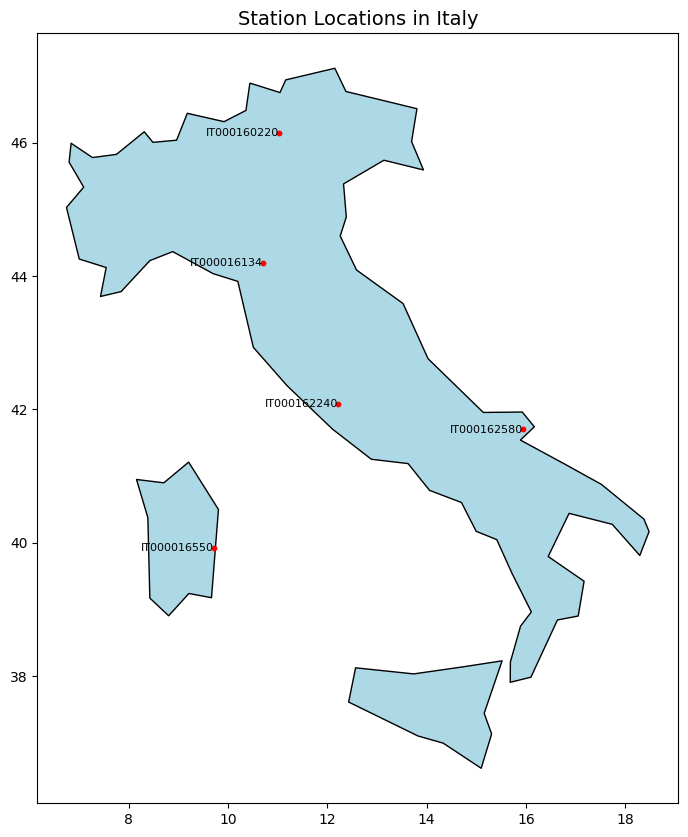

In [ ]:
plot_station_map(station_info_list)

- **Initialize Storage**:  
  - Creates an empty dictionary `tmax_tmin_all_stations` to store TMAX and TMIN data for each station.

- **Loop Through Stations**:  
  - For each station in `station_info_list`:
    - Retrieves the station ID.
    - Calls `extract_tmax_tmin_for_station` with the base directory, station ID, and `ghn` instance to extract TMAX and TMIN dates and values.
    - Stores the extracted data in the dictionary under the corresponding station ID.

- **Print Summary**:  
  - Iterates over the collected data and prints:
    - The station ID.
    - The number of TMAX entries.
    - The number of TMIN entries.


In [ ]:

tmax_tmin_all_stations = {}

for station in station_info_list:
    station_id = station['station_id']


    tmax_dates, tmax_values, tmin_dates, tmin_values = extract_tmax_tmin_for_station(
        base_dir=base_dir,
        station_id=station_id,
        ghn=ghn
    )

    tmax_tmin_all_stations[station_id] = {
        'tmax_dates': tmax_dates,
        'tmax_values': tmax_values,
        'tmin_dates': tmin_dates,
        'tmin_values': tmin_values
    }

for st_id, data_dict in tmax_tmin_all_stations.items():
    print(f"Station {st_id}:")
    print(f"  TMAX entries: {len(data_dict['tmax_values'])}")
    print(f"  TMIN entries: {len(data_dict['tmin_values'])}")
    print()

Station IT000016134:
  TMAX entries: 22342
  TMIN entries: 21831

Station IT000016550:
  TMAX entries: 24615
  TMIN entries: 23439

Station IT000160220:
  TMAX entries: 23536
  TMIN entries: 22907

Station IT000162240:
  TMAX entries: 22977
  TMIN entries: 21752

Station IT000162580:
  TMAX entries: 23996
  TMIN entries: 22936



- **Purpose**:  
  - Creates a summary table (DataFrame) that reports for each station:
    - The start and end years of available data.
    - Any missing years within that period.
    - Years that are incomplete (i.e., missing one or more months), along with the missing months.

- **Process Overview**:  
  - Iterates over a list of station IDs.
  - For each station:
    - Constructs the file path and checks if the corresponding .dly file exists.
    - Processes the file using `ghn.processFile` to extract the data.
    - Builds a dictionary mapping each year to a set of months for which data is available.
    - Determines the start and end years from the available data.
    - Identifies missing years and incomplete years (with missing months).
    - Appends a dictionary of these summary details to a list.

- **Return Value**:  
  - Converts the list of summaries into a pandas DataFrame and returns it.


In [ ]:

def create_station_date_summary_table(base_dir, station_ids, ghn):
    """
    Creates a summary table for each station that includes:
      1. The start and end years of available data.
      2. The missing years in between.
      3. The years that do not have a complete dataset (data for every month)
         and which months are missing.

    Parameters:
    -----------
    base_dir : str
        The directory where the .dly files for each station are stored.
    station_ids : list of str
        A list of station IDs to process.
    ghn : GHNCD
        An instance of the GHNCD class used to process the .dly files.

    Returns:
    --------
    df_summary : pandas.DataFrame
        A table summarizing the available dates for each station.
    """
    summary_list = []

    for station_id in station_ids:
        file_path = os.path.join(base_dir, f"{station_id}.dly")
        if not os.path.isfile(file_path):
            print(f"File not found for station {station_id}. Skipping...")
            continue

        station_data = ghn.processFile(file_path)
        year_to_months = defaultdict(set)
        for field_dict in station_data.values():
            for month_info in field_dict['monthList']:
                year = month_info['year']
                month = month_info['month']
                year_to_months[year].add(month)

        if not year_to_months:
            print(f"No data found for station {station_id}.")
            continue

        years_present = sorted(year_to_months.keys())
        start_year = min(years_present)
        end_year = max(years_present)


        missing_years = [y for y in range(start_year, end_year + 1) if y not in year_to_months]


        incomplete_years = {}
        for y in years_present:
            months_present = year_to_months[y]
            if len(months_present) < 12:
                missing_months = sorted(set(range(1, 13)) - months_present)
                incomplete_years[y] = missing_months

        summary_list.append({
            'Station': station_id,
            'Start Year': start_year,
            'End Year': end_year,
            'Missing Years': ', '.join(map(str, missing_years)) if missing_years else 'None',
            'Incomplete Years': '; '.join([f"{y}: {missing}" for y, missing in incomplete_years.items()]) if incomplete_years else 'None'
        })

    df_summary = pd.DataFrame(summary_list)
    return df_summary


- **Function: wrap_text**
  - Checks if the input `s` is a string; if not, converts it.
  - If the string is shorter than or equal to the specified `wrap_chars` (default 30), returns it unchanged.
  - Otherwise, splits the string into chunks of `wrap_chars` characters.
  - Joins these chunks with newline characters to produce a wrapped version of the text.

- **Function: save_table_as_image_centered**
  - **Purpose**: Saves a pandas DataFrame as an image with a centered, well-formatted table.
  - Sets the pandas option to display unlimited column width.
  - If specified, applies `wrap_text` to chosen columns (`wrap_columns`) to insert line breaks for long text.
  - Converts the DataFrame into a list of lists (`cell_text`) and extracts column labels.
  - Dynamically calculates the figure height based on the number of rows.
  - Creates a matplotlib figure and axis, then disables axis lines.
  - Uses `ax.table` to render the table in the center with cells and column labels centered.
  - Manually sets the font size and adjusts the header cell colors and text properties.
  - Automatically adjusts column widths and scales the table for proper display.
  - Uses `tight_layout` and saves the resulting table as an image file (filename provided).
  - Closes the figure to free resources.


In [ ]:
def wrap_text(s, wrap_chars=30):
    """
    Inserts line breaks into the string `s` every `wrap_chars` characters
    to ensure it fits in the cell without overflowing horizontally.
    """
    if not isinstance(s, str):
        s = str(s)
    if len(s) <= wrap_chars:
        return s

    lines = []
    start = 0
    while start < len(s):
        lines.append(s[start:start+wrap_chars])
        start += wrap_chars
    return "\n".join(lines)

def save_table_as_image_centered(df, filename, fontsize=10, header_color='#40466e',
                                 cell_color='#f1f1f2', wrap_columns=None, wrap_chars=30):
    """
    Saves a Pandas DataFrame as an image using matplotlib's table functionality.
    Ensures:
      1. Long text is wrapped into multiple lines,
      2. Text is centered horizontally and vertically,
      3. Row heights are scaled so multiline text is fully visible.

    Parameters
    ----------
    df : pandas.DataFrame
        The DataFrame to be rendered as a table.
    filename : str
        Output image file name (e.g., 'table.png').
    fontsize : int, optional
        Font size for the table text.
    header_color : str, optional
        Background color for the header row.
    cell_color : str, optional
        Background color for the data cells.
    wrap_columns : list of str, optional
        Names of columns to wrap if content is long (default: None).
    wrap_chars : int, optional
        Number of characters after which to insert a line break (default: 30).
    """


    pd.set_option('display.max_colwidth', None)


    if wrap_columns:
        df = df.copy()
        for col in wrap_columns:
            if col in df.columns:
                df[col] = df[col].apply(lambda x: wrap_text(x, wrap_chars=wrap_chars))

    cell_text = df.values.tolist()
    col_labels = df.columns.tolist()

    fig_height = 0.6 * (len(df) + 1)
    fig, ax = plt.subplots(figsize=(12, fig_height))
    ax.axis('tight')
    ax.axis('off')


    table = ax.table(
        cellText=cell_text,
        colLabels=col_labels,
        loc='center',
        cellLoc='center',
        colLoc='center'
    )

    table.auto_set_font_size(False)
    table.set_fontsize(fontsize)


    for (row, col), cell in table.get_celld().items():
        if row == 0:

            cell.set_facecolor(header_color)
            cell.set_text_props(color='white', weight='bold', ha='center', va='center')
        else:

            cell.set_facecolor(cell_color)
            cell.set_text_props(ha='center', va='center')


    table.auto_set_column_width(col=list(range(len(col_labels))))

    table.scale(1, 1.2)

    plt.tight_layout()
    plt.savefig(filename, bbox_inches='tight')
    plt.close(fig)

- **Define Station IDs**:  
  - Creates a list of station IDs for which the summary will be generated.
  
- **Create Summary Table**:  
  - Calls `create_station_date_summary_table` with the base directory, station IDs, and the `ghn` instance.
  - Generates a pandas DataFrame summarizing each station’s data availability (start/end years, missing years, incomplete years).

- **Save Table as Image**:  
  - Uses `save_table_as_image_centered` to save the summary DataFrame as a centered image file named "station_summary.png".


In [ ]:
station_ids = ['IT000016134','IT000016550', 'IT000160220', 'IT000162240', 'IT000162580']
df_table = create_station_date_summary_table(base_dir, station_ids, ghn)
save_table_as_image_centered(df_table, "station_summary.png")

- **Function Purpose**:  
  - Combines TMAX and TMIN data from multiple stations into a single DataFrame with calculated average temperatures.

- **For Each Station**:
  - Extracts TMAX/TMIN dates and values from the input dictionary.
  - Creates separate DataFrames for TMAX (`df_tmax`) and TMIN (`df_tmin`).
  - Merges these DataFrames on the "date" column (inner join) and adds a "station_id" column.
  - Converts the "date" column to datetime format.
  - Computes the average temperature (`avg_temp`) as the mean of TMAX and TMIN.
  - Drops any rows with missing data.
  - Appends the cleaned DataFrame to a list.

- **After the Loop**:
  - Concatenates all station DataFrames into one combined DataFrame (`df_combined`).
  - Sets "date" as the index.
  - Groups by `station_id` and resamples the average temperature to a monthly frequency, computing the mean.
  - Resets the index for the monthly average DataFrame.

- **Output**:
  - Prints the head of the combined DataFrame.
  - Displays the head of the monthly average DataFrame.


In [ ]:
def create_combined_df(tmax_tmin_all_stations):
    """
    Takes a dictionary of station data (tmax_tmin_all_stations) and returns
    a single DataFrame (df_combined) containing:
      - station_id
      - date
      - tmax
      - tmin
      - avg_temp

    Parameters
    ----------
    tmax_tmin_all_stations : dict
        A dict where each key is a station_id and each value is another dict:
          {
            'tmax_dates': [...],
            'tmax_values': [...],
            'tmin_dates': [...],
            'tmin_values': [...]
          }

    Returns
    -------
    df_combined : pandas.DataFrame
        Columns: ['station_id', 'date', 'tmax', 'tmin', 'avg_temp']
        Index: numeric (reset_index)
    """

    all_dfs = []

    for station_id, data_dict in tmax_tmin_all_stations.items():

        tmax_dates = data_dict['tmax_dates']
        tmax_values = data_dict['tmax_values']
        tmin_dates = data_dict['tmin_dates']
        tmin_values = data_dict['tmin_values']


        df_tmax = pd.DataFrame({'date': tmax_dates, 'tmax': tmax_values})
        df_tmin = pd.DataFrame({'date': tmin_dates, 'tmin': tmin_values})


        df_merged = pd.merge(df_tmax, df_tmin, on='date', how='inner')

        df_merged['station_id'] = station_id


        df_merged['date'] = pd.to_datetime(df_merged['date'])
        df_merged['avg_temp'] = (df_merged['tmax'] + df_merged['tmin']) / 2
        df_merged.dropna(inplace=True)


        all_dfs.append(df_merged)


    df_combined = pd.concat(all_dfs, ignore_index=True)

    return df_combined


df_combined = create_combined_df(tmax_tmin_all_stations)

df_combined.set_index('date', inplace=True)

monthly_avg = df_combined.groupby('station_id')['avg_temp'].resample('M').mean().dropna()

monthly_avg = monthly_avg.reset_index()

print("df_combined (head):")
print(df_combined.head())

print("\nmonthly_avg (head):")
display(monthly_avg.head(10))

df_combined (head):
            tmax  tmin   station_id  avg_temp
date                                         
1951-01-01   0.4  -6.4  IT000016134      -3.0
1951-01-02   0.5  -4.3  IT000016134      -1.9
1951-01-03  -1.0  -2.0  IT000016134      -1.5
1951-01-04   0.4  -2.2  IT000016134      -0.9
1951-01-05  -0.6  -2.4  IT000016134      -1.5

monthly_avg (head):


<ipython-input-97-a20ed1075ead>:76: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_avg = df_combined.groupby('station_id')['avg_temp'].resample('M').mean().dropna()


station_id       date   avg_temp
0  IT000016134 1951-01-31  -3.391935
1  IT000016134 1951-02-28  -3.619643
2  IT000016134 1951-03-31  -3.793548
3  IT000016134 1951-04-30  -2.003333
4  IT000016134 1951-05-31   2.041935
5  IT000016134 1951-06-30   7.980000
6  IT000016134 1951-07-31   9.562903
7  IT000016134 1951-08-31  10.409677
8  IT000016134 1951-09-30   8.083333
9  IT000016134 1951-10-31  -0.104839

- **Parameters Set**:  
  - Defines a window size and forecast horizon of 12 months each.

- **Initialization**:  
  - Creates empty lists for `features`, `targets`, and `station_for_sample`.

- **Group Data by Station**:  
  - Groups the `monthly_avg` DataFrame by `station_id`.

- **Sliding Window Loop per Station**:  
  - Sorts each station's data by date.
  - Extracts the average temperature values.
  - Iterates over the temperature series to:
    - Use 12 months as the input window (`x`).
    - Use the following 12 months as the forecast target (`y`).
    - Records the corresponding station ID.

- **Final Steps**:  
  - Converts the lists into NumPy arrays.
  - Prints the shapes of the `features` and `targets` arrays.


In [ ]:
window_size = 12
forecast_horizon = 12

features = []
targets = []
station_for_sample = []

grouped = monthly_avg.groupby('station_id')

for station_id, group_df in grouped:

    group_df = group_df.sort_values(by='date')


    station_values = group_df['avg_temp'].values

    station_dates = group_df['date'].values


    for i in range(len(station_values) - window_size - forecast_horizon + 1):

        x = station_values[i : i + window_size]

        y = station_values[i + window_size : i + window_size + forecast_horizon]

        features.append(x)
        targets.append(y)
        station_for_sample.append(station_id)


features = np.array(features)
targets = np.array(targets)

print("features.shape:", features.shape)
print("targets.shape:", targets.shape)

features.shape: (3941, 12)
targets.shape: (3941, 12)


- **Compute Training Set Size**:  
  - Calculates an 80% split of the total number of samples.
  
- **Split Features and Targets**:  
  - Assigns the first 80% of the features and targets to the training set (`X_train`, `y_train`).
  - Assigns the remaining 20% to the test set (`X_test`, `y_test`).

- **Print Shapes**:  
  - Displays the shapes of the training and test arrays for both features and targets.


In [ ]:
train_size = int(len(features) * 0.8)

X_train = features[:train_size]
y_train = targets[:train_size]
X_test  = features[train_size:]
y_test  = targets[train_size:]

print("X_train.shape:", X_train.shape)
print("y_train.shape:", y_train.shape)
print("X_test.shape:", X_test.shape)
print("y_test.shape:", y_test.shape)

X_train.shape: (3152, 12)
y_train.shape: (3152, 12)
X_test.shape: (789, 12)
y_test.shape: (789, 12)


- **Reshape Training Data**:  
  - Reshapes `X_train` to add a third dimension (feature dimension), making its shape (samples, time steps, 1).  
- **Reshape Test Data**:  
  - Similarly reshapes `X_test` for compatibility with Keras LSTM/RNN layers.


In [ ]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test  = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

- **Build Combined LSTM Model**:  
  - Calls `build_LSTM_model` to create an LSTM model with:
    - 12 input time steps, a 12-month forecast horizon.
    - 128 LSTM units.
    - 2 LSTM layers (stacked).
    - 'relu' activation and 'adam' optimizer (default learning rate).

- **Early Stopping Setup**:  
  - Configures an EarlyStopping callback to monitor validation loss with a patience of 5 epochs and restores the best weights.

- **Train the Model**:  
  - Trains the model on `X_train` and `y_train` for up to 100 epochs with a batch size of 16.
  - Uses 20% of the training data as a validation set.
  - Displays training progress with verbosity.

- **Evaluate the Model**:  
  - Evaluates the trained model on the test set (`X_test`, `y_test`) to obtain the MSE.
  - Prints the MSE for the LSTM model trained on the combined dataset.


In [ ]:
model_LSTM_combined = build_LSTM_model(
    input_timesteps=12,
    output_horizon=12,
    lstm_units=128,
    num_layers=2,
    dropout_rate=0.0,
    recurrent_dropout_rate=0.0,
    activation='relu',
    optimizer='adam',
    learning_rate=None)

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history_LSTM_combined = model_LSTM_combined.fit(X_train, y_train, epochs=100, batch_size=16,
                    validation_split=0.2, callbacks=[early_stop], verbose=1)

mse_LSTM_combined =  model_LSTM_combined.evaluate(X_test, y_test)
print('MSE for LSTM for a combined dataframe', mse_LSTM_combined)

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


158/158 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - loss: 35.2400 - val_loss: 3.2523
Epoch 2/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step - loss: 4.1768 - val_loss: 3.0898
Epoch 3/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - loss: 3.7393 - val_loss: 3.2316
Epoch 4/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step - loss: 3.7762 - val_loss: 3.1254
Epoch 5/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - loss: 3.6166 - val_loss: 2.8737
Epoch 6/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - loss: 3.5565 - val_loss: 2.9323
Epoch 7/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 11s 40ms/step - loss: 3.6655 - val_loss: 2.7055
Epoch 8/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - loss: 3.5351 - val_loss: 2.5654
Epoch 9/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - loss: 3.4469 - val_loss: 2.6239
Epoch 10/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - loss: 3.2996 - val_loss: 3.0251
Epoch 11/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - loss: 3.5126 - val_loss: 2.5535
Epoch 12/100
158/158 ━━━━━━━━━━━━━━━━━━

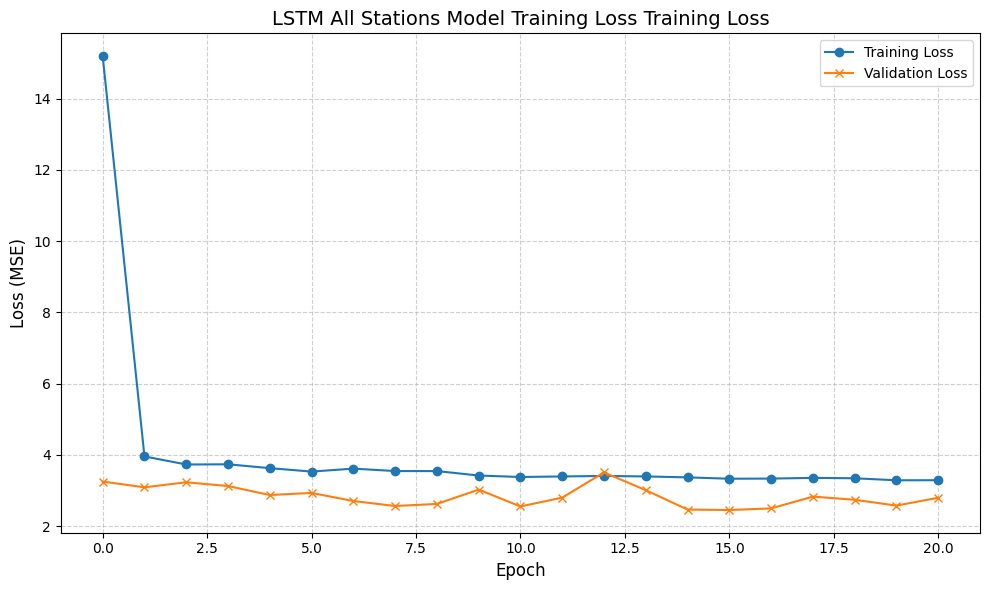

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'LSTM All Stations Model Training Loss Training Loss'}, xlabel='Epoch', ylabel='Loss (MSE)'>)

In [ ]:
plot_model_loss(history_LSTM_combined, model_name = 'LSTM All Stations Model Training Loss')

25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step


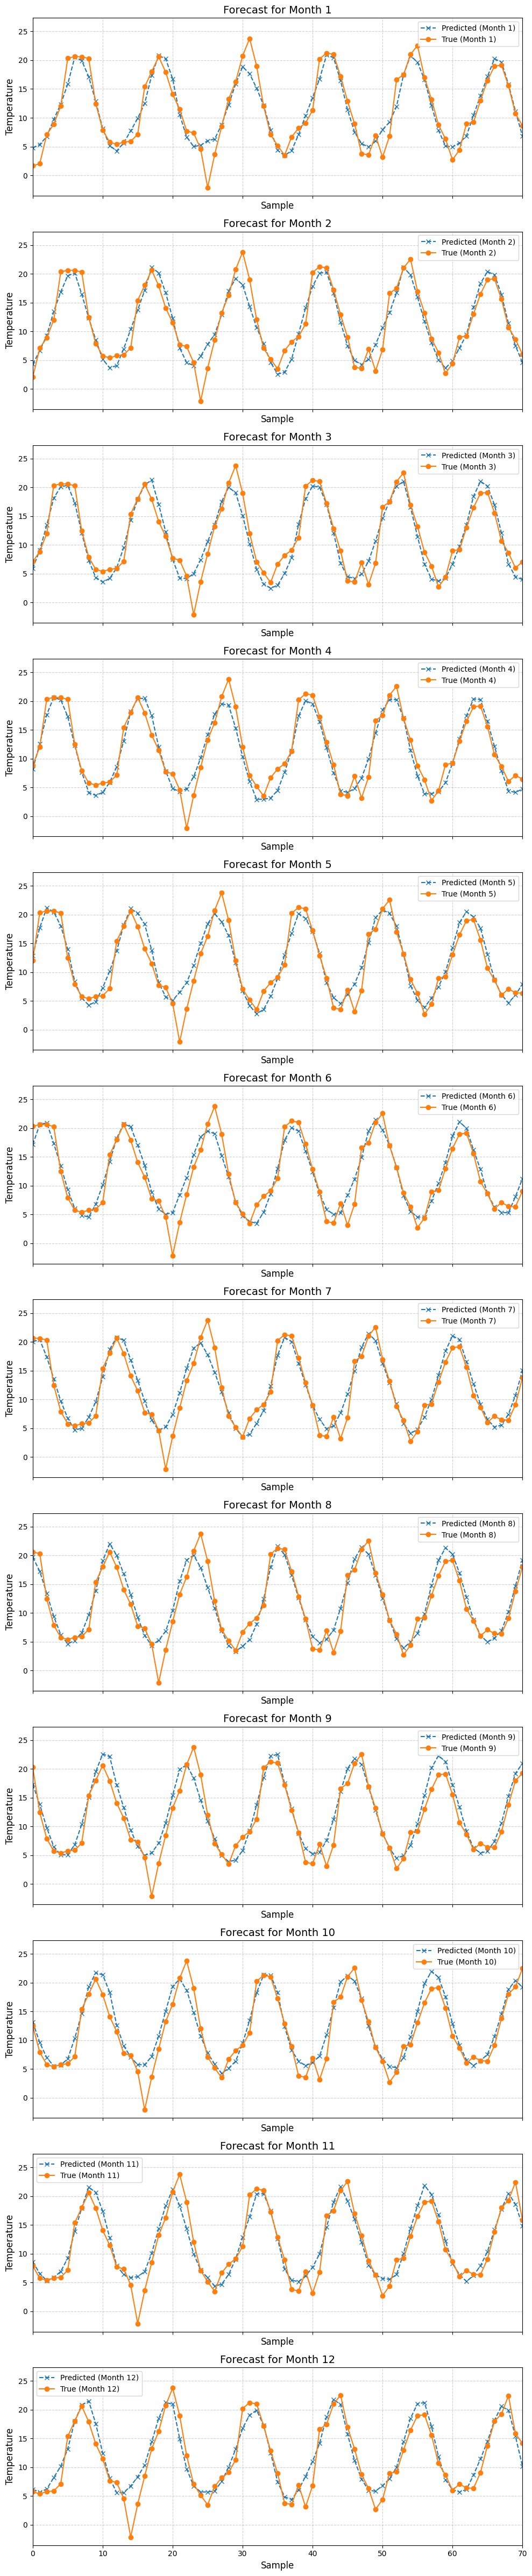

(<Figure size 1000x4800 with 12 Axes>,
 array([<Axes: title={'center': 'Forecast for Month 1'}, xlabel='Sample', ylabel='Temperature'>,
        <Axes: title={'center': 'Forecast for Month 2'}, xlabel='Sample', ylabel='Temperature'>,
        <Axes: title={'center': 'Forecast for Month 3'}, xlabel='Sample', ylabel='Temperature'>,
        <Axes: title={'center': 'Forecast for Month 4'}, xlabel='Sample', ylabel='Temperature'>,
        <Axes: title={'center': 'Forecast for Month 5'}, xlabel='Sample', ylabel='Temperature'>,
        <Axes: title={'center': 'Forecast for Month 6'}, xlabel='Sample', ylabel='Temperature'>,
        <Axes: title={'center': 'Forecast for Month 7'}, xlabel='Sample', ylabel='Temperature'>,
        <Axes: title={'center': 'Forecast for Month 8'}, xlabel='Sample', ylabel='Temperature'>,
        <Axes: title={'center': 'Forecast for Month 9'}, xlabel='Sample', ylabel='Temperature'>,
        <Axes: title={'center': 'Forecast for Month 10'}, xlabel='Sample', ylabel='Tempe

In [ ]:
plot_predictions_by_horizon(model_LSTM_combined, X_test, y_test, xlim=(0, 70))

- **Extract Naive Predictions**:  
  - Takes the last `forecast_horizon` columns from the `features` array as naive predictions.

- **Compute Naive MSE**:  
  - Calculates the mean squared error between these naive predictions and the actual `targets`.

- **Output Result**:  
  - Prints the computed Naive Baseline MSE.


In [ ]:
naive_preds = features[:, -forecast_horizon:]
mse_naive = np.mean((naive_preds - targets)**2)
print("Naive Baseline MSE:", mse_naive)

Naive Baseline MSE: 5.133168450782904


- **Build RNN Model**:  
  - Calls `build_simple_rnn` to create an RNN model with:
    - 12 input time steps, a forecast horizon of 12.
    - 64 RNN units in a single layer, using 'relu' activation and the Adam optimizer.

- **Configure Early Stopping**:  
  - Sets up an EarlyStopping callback to monitor validation loss, with a patience of 5 epochs and restoring the best weights.

- **Train the RNN Model**:  
  - Trains the model on the training data (`X_train`, `y_train`) for up to 100 epochs and a batch size of 16, using 20% of the training data for validation.

- **Evaluate and Print MSE**:  
  - Evaluates the trained model on the test set (`X_test`, `y_test`) to compute the Mean Squared Error (MSE).
  - Prints the MSE for the RNN model trained on the combined dataset.


In [ ]:
model_RNN_combined = build_simple_rnn(
    input_timesteps=12,
    output_horizon=12,
    rnn_units=64,
    num_layers=1,
    dropout_rate=0.0,
    activation='relu',
    optimizer='adam',
    learning_rate=None)

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history_RNN_combined = model_RNN_combined.fit(X_train, y_train, epochs=100, batch_size=16,
                    validation_split=0.2, callbacks=[early_stop], verbose=1)

mse_RNN_combined = model_RNN_combined.evaluate(X_test, y_test)
print('MSE for RNN for a combined dataframe', mse_RNN_combined)

Epoch 1/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 61.4901 - val_loss: 3.5818
Epoch 2/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 4.3098 - val_loss: 3.1602
Epoch 3/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 3.9317 - val_loss: 3.3513
Epoch 4/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 3.8783 - val_loss: 2.6377
Epoch 5/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 3.7532 - val_loss: 2.8484
Epoch 6/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 3.6718 - val_loss: 2.5539
Epoch 7/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 3.6172 - val_loss: 2.8647
Epoch 8/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 3.5722 - val_loss: 2.9198
Epoch 9/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 3.6180 - val_loss: 2.4736
Epoch 10/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 3.5783 - val_loss: 2.4043
Epoch 11/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 3.4433 - val_loss: 2.4709
Epoch 12/100
158/158 ━━━━━━━━━━━━━━━━━

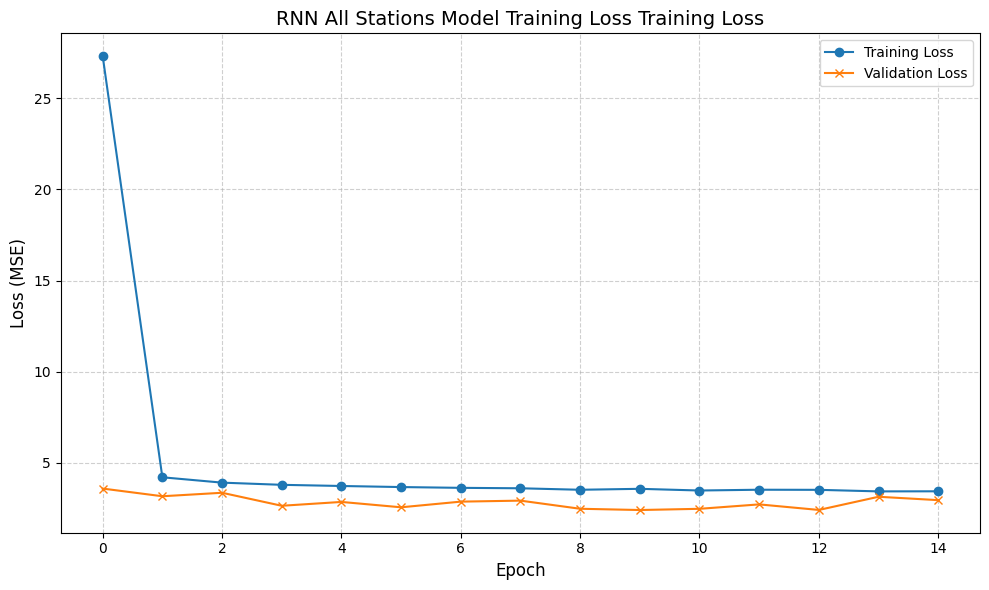

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'RNN All Stations Model Training Loss Training Loss'}, xlabel='Epoch', ylabel='Loss (MSE)'>)

In [ ]:
plot_model_loss(history_RNN_combined, model_name = 'RNN All Stations Model Training Loss')

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


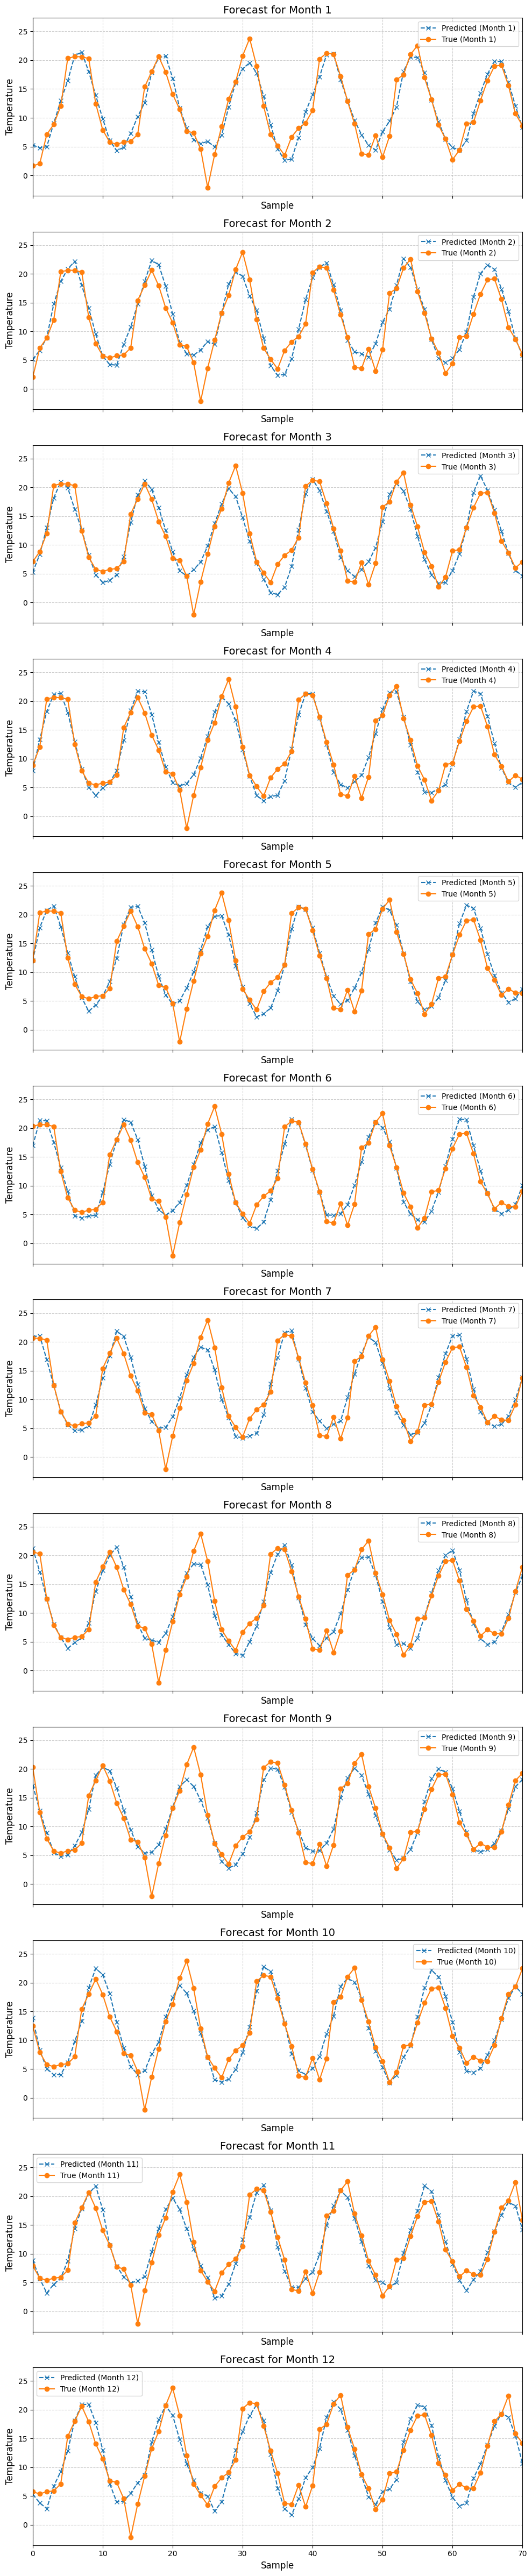

(<Figure size 1000x4800 with 12 Axes>,
 array([<Axes: title={'center': 'Forecast for Month 1'}, xlabel='Sample', ylabel='Temperature'>,
        <Axes: title={'center': 'Forecast for Month 2'}, xlabel='Sample', ylabel='Temperature'>,
        <Axes: title={'center': 'Forecast for Month 3'}, xlabel='Sample', ylabel='Temperature'>,
        <Axes: title={'center': 'Forecast for Month 4'}, xlabel='Sample', ylabel='Temperature'>,
        <Axes: title={'center': 'Forecast for Month 5'}, xlabel='Sample', ylabel='Temperature'>,
        <Axes: title={'center': 'Forecast for Month 6'}, xlabel='Sample', ylabel='Temperature'>,
        <Axes: title={'center': 'Forecast for Month 7'}, xlabel='Sample', ylabel='Temperature'>,
        <Axes: title={'center': 'Forecast for Month 8'}, xlabel='Sample', ylabel='Temperature'>,
        <Axes: title={'center': 'Forecast for Month 9'}, xlabel='Sample', ylabel='Temperature'>,
        <Axes: title={'center': 'Forecast for Month 10'}, xlabel='Sample', ylabel='Tempe

In [ ]:
plot_predictions_by_horizon(model_RNN_combined, X_test, y_test, xlim=(0, 70))

---
# Extension prediction of 10 years

- **Set Parameters**:  
  - `window_size = 12`: Number of months used as input.
  - `forecast_horizon = 120`: Number of months ahead to forecast.

- **Initialize Lists**:  
  - `features`, `targets`, and `station_for_sample` are initialized to store inputs, outputs, and corresponding station IDs.

- **Group Data by Station**:  
  - The `monthly_avg` DataFrame is grouped by `station_id`.

- **Sliding Window Loop**:  
  - For each station:
    - The data is sorted by date.
    - The average temperature values are extracted.
    - A loop creates sliding windows:
      - `x`: A window of 12 consecutive monthly average temperatures.
      - `y`: The subsequent 120 months as the forecast target.
    - Appends `x`, `y`, and the station ID to their respective lists.

- **Convert to NumPy Arrays**:  
  - The lists for features and targets are converted to NumPy arrays for further processing.


In [ ]:
window_size = 12
forecast_horizon = 120

features = []
targets = []
station_for_sample = []

grouped = monthly_avg.groupby('station_id')

for station_id, group_df in grouped:
    group_df = group_df.sort_values(by='date')
    station_values = group_df['avg_temp'].values

    for i in range(len(station_values) - window_size - forecast_horizon + 1):
        x = station_values[i : i + window_size]
        y = station_values[i + window_size : i + window_size + forecast_horizon]

        features.append(x)
        targets.append(y)
        station_for_sample.append(station_id)

features = np.array(features)
targets = np.array(targets)

- **Calculate Training Set Size**:  
  - Computes 80% of the total number of feature samples to determine the training set size.

- **Split Data**:  
  - Divides the features and targets arrays into training (`X_train`, `y_train`) and test sets (`X_test`, `y_test`) based on the calculated size.

- **Print Shapes**:  
  - Prints the shapes of the training and test sets for both features and targets to verify the split.


In [ ]:
train_size = int(len(features) * 0.8)

X_train = features[:train_size]
y_train = targets[:train_size]
X_test  = features[train_size:]
y_test  = targets[train_size:]

print("X_train.shape:", X_train.shape)
print("y_train.shape:", y_train.shape)
print("X_test.shape:", X_test.shape)
print("y_test.shape:", y_test.shape)

X_train.shape: (2720, 12)
y_train.shape: (2720, 120)
X_test.shape: (681, 12)
y_test.shape: (681, 120)


- **Reshape Training Data**:  
  - Changes `X_train` shape from (samples, timesteps) to (samples, timesteps, 1) by adding a feature dimension.
- **Reshape Test Data**:  
  - Similarly reshapes `X_test` to include a feature dimension, making it compatible with LSTM/RNN layers.


In [ ]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test  = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

- **Build LSTM Model**:
  - Uses `build_LSTM_model` with:
    - 12 input time steps and a forecast horizon of 120 months.
    - 128 LSTM units in 2 layers, with no dropout.
    - 'relu' activation and the Adam optimizer.
- **Early Stopping**:
  - Sets up an EarlyStopping callback monitoring validation loss with a patience of 5 epochs and restores the best weights.
- **Train Model**:
  - Fits the LSTM model on the training data (`X_train`, `y_train`) for up to 100 epochs, using a batch size of 16 and a 20% validation split.
- **Evaluate Model**:
  - Evaluates the trained model on the test data (`X_test`, `y_test`) to compute the Mean Squared Error (MSE).
  - Prints the MSE result for the LSTM model on the combined dataset.


In [ ]:
model_LSTM_10 = build_LSTM_model(input_timesteps=12,
                                 output_horizon=120,
                                 lstm_units = 128,
                                 num_layers = 2,
                                 dropout_rate= 0.0,
                                 recurrent_dropout_rate=0.0,
                                 activation='relu',
                                 optimizer = 'adam',
                                 learning_rate= None)

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history_LSTM_10 = model_LSTM_10.fit(X_train, y_train, epochs=100, batch_size=16,
                    validation_split=0.2, callbacks=[early_stop], verbose=1)

mse_LSTM_10 = model_LSTM_10.evaluate(X_test, y_test)
print('MSE for LSTM for a combined dataframe', mse_LSTM_10)

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


136/136 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - loss: 60.7785 - val_loss: 7.5020
Epoch 2/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 5.4544 - val_loss: 5.1975
Epoch 3/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 4.8907 - val_loss: 6.4727
Epoch 4/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - loss: 4.6691 - val_loss: 6.7220
Epoch 5/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - loss: 4.5251 - val_loss: 4.5180
Epoch 6/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - loss: 4.3388 - val_loss: 5.3729
Epoch 7/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - loss: 4.3822 - val_loss: 5.2973
Epoch 8/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - loss: 4.4152 - val_loss: 4.6261
Epoch 9/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 4.3796 - val_loss: 5.9643
Epoch 10/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 4.7406 - val_loss: 4.3095
Epoch 11/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - loss: 4.1674 - val_loss: 5.0047
Epoch 12/100
136/136 ━━━━━━━━━━━━━━━━━━

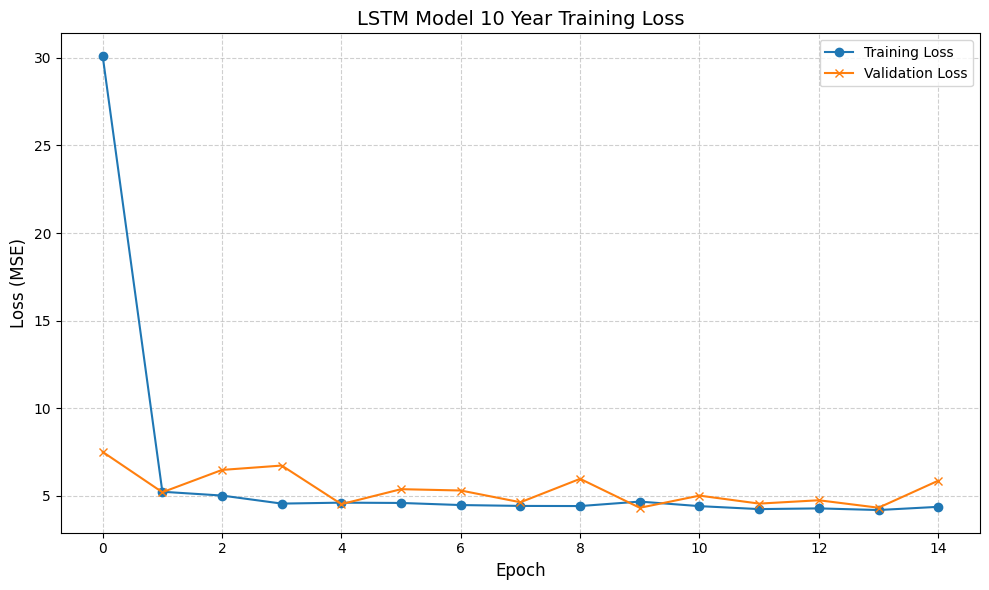

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'LSTM Model 10 Year Training Loss'}, xlabel='Epoch', ylabel='Loss (MSE)'>)

In [ ]:
plot_model_loss(history_LSTM_10, model_name = 'LSTM Model 10 Year')

22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step


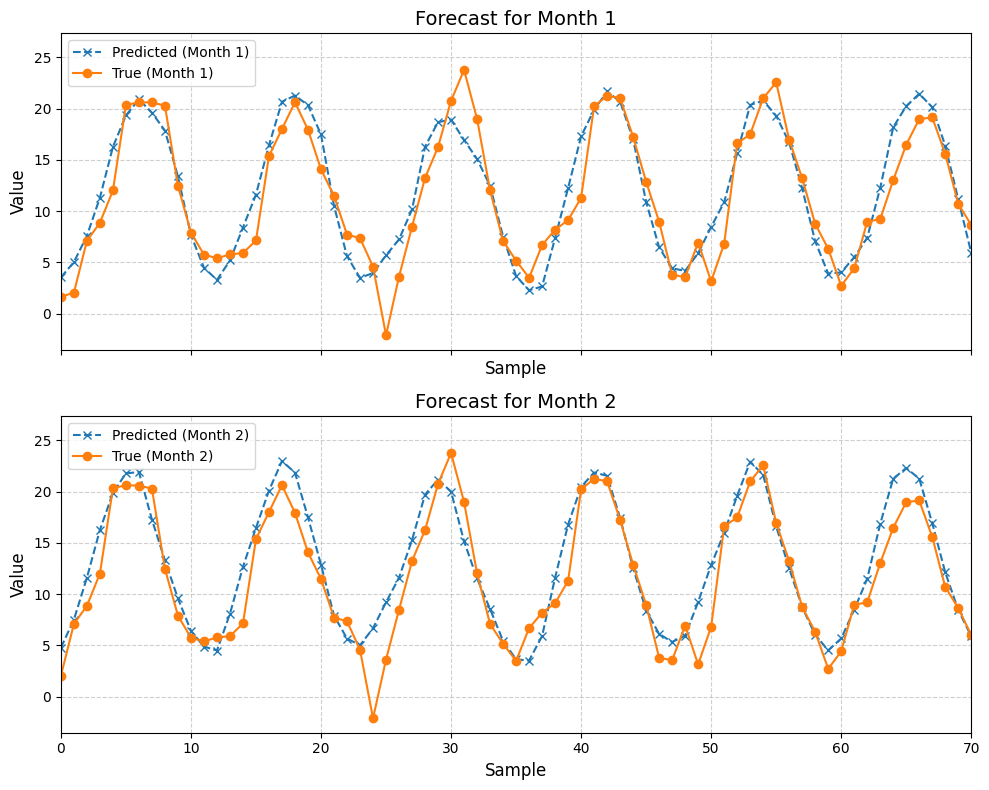

(<Figure size 1000x800 with 2 Axes>,
 array([<Axes: title={'center': 'Forecast for Month 1'}, xlabel='Sample', ylabel='Value'>,
        <Axes: title={'center': 'Forecast for Month 2'}, xlabel='Sample', ylabel='Value'>],
       dtype=object))

In [ ]:
plot_predictions_by_horizon(model_LSTM_10, X_test, y_test, xlim = (0, 70), horizons_to_plot=[0,1])

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


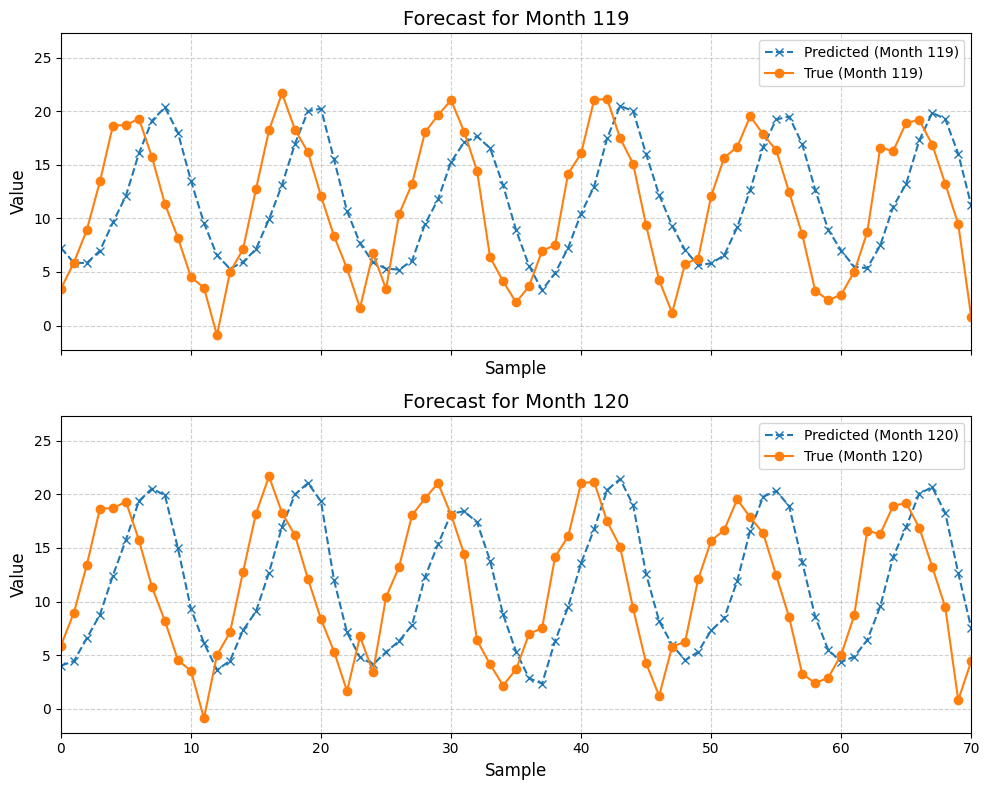

(<Figure size 1000x800 with 2 Axes>,
 array([<Axes: title={'center': 'Forecast for Month 119'}, xlabel='Sample', ylabel='Value'>,
        <Axes: title={'center': 'Forecast for Month 120'}, xlabel='Sample', ylabel='Value'>],
       dtype=object))

In [ ]:
plot_predictions_by_horizon(model_LSTM_10, X_test, y_test, xlim = (0, 70), horizons_to_plot=[118,119])

---
# Individual extenstion: assessing the contributions of each station



*   Previously I combined the data for all stations in italy and assumed that they all contributed positively to the training of the LSTM/RNN as they increased the size of the data set. Now the point of this extension is to create different combinations of the datasets for the stations and see which combinations perform best for the models.



- **Function: get_filtered_monthly_avg**
  - Creates a combined DataFrame from station data using `create_combined_df`.
  - Sets 'date' as the index.
  - Filters out rows for stations whose IDs are in the `stations_to_remove` list.
  - Groups the remaining data by station and resamples it monthly, computing the mean average temperature.
  - Returns the resulting monthly average DataFrame.

- **Function: evaluate_models**
  - Converts monthly average data into sliding window features and targets:
    - Uses a window of a fixed number of months (`window_size`) as input.
    - Uses the subsequent months (`forecast_horizon`) as the forecast target.
  - Computes a naive baseline MSE (by copying the input window as predictions).
  - Splits the data into training (80%) and testing (20%) sets.
  - Reshapes the features for compatibility with LSTM/RNN layers.
  - Builds, trains, and evaluates an LSTM model using early stopping.
  - Builds, trains, and evaluates a SimpleRNN model using early stopping.
  - Returns a dictionary containing the MSE values for the naive baseline, LSTM, and RNN models, along with the total number of samples.

- **Function: compare_results**
  - Prints a side-by-side comparison of the baseline model MSEs and the new model MSEs (for LSTM, RNN, and naive baseline).
  - Checks whether the new LSTM and RNN MSEs are lower than the baseline results and prints messages indicating improvement.

- **Function: evaluate_station_removal**
  - Evaluates the effect of removing specified stations from the dataset.
  - If no baseline results are provided, computes baseline performance using all stations.
  - Filters the monthly average data to remove the specified stations.
  - Trains and evaluates models on the filtered data.
  - Appends a suffix (derived from the last three digits of removed station IDs) to the MSE keys for clarity.
  - Prints and compares the new model results against the baseline using `compare_results`.
  - Returns both the new results (with suffixed keys) and the baseline results.

- **Function: compute_percentage_difference**
  - Calculates the percentage improvement (or decline) of the model MSEs relative to the naive baseline MSE.
  - Expects keys for the naive, LSTM, and RNN MSEs to include a common suffix.
  - Computes the percentage difference as ((naive - model) / naive) * 100.
  - Returns a dictionary with the percentage differences for the LSTM and RNN models.


In [ ]:

def get_filtered_monthly_avg(tmax_tmin_all_stations, stations_to_remove):
    """
    Creates the combined dataframe (df_combined) and computes monthly average temperatures.
    Filters out any stations whose IDs are in stations_to_remove.
    """
    df_combined = create_combined_df(tmax_tmin_all_stations)
    df_combined.set_index('date', inplace=True)
    if stations_to_remove:
        df_combined = df_combined[~df_combined['station_id'].isin(stations_to_remove)]
        print(f"Removed stations: {stations_to_remove}")
    monthly_avg = df_combined.groupby('station_id')['avg_temp'].resample('M').mean().dropna().reset_index()
    return monthly_avg

def evaluate_models(monthly_avg, window_size=12, forecast_horizon=12):
    """
    Creates sliding window features/targets from monthly_avg data,
    splits into training and testing sets, trains LSTM and RNN models,
    computes a naive baseline (using the input window as forecast),
    and returns their MSEs.
    """
    features = []
    targets = []

    grouped = monthly_avg.groupby('station_id')
    for station_id, group_df in grouped:
        group_df = group_df.sort_values('date')
        station_values = group_df['avg_temp'].values

        for i in range(len(station_values) - window_size - forecast_horizon + 1):
            x = station_values[i : i + window_size]
            y = station_values[i + window_size : i + window_size + forecast_horizon]
            features.append(x)
            targets.append(y)
    features = np.array(features)
    targets = np.array(targets)


    naive_preds = features.copy()
    mse_naive = np.mean((naive_preds - targets) ** 2)

    train_size = int(len(features) * 0.8)
    X_train, y_train = features[:train_size], targets[:train_size]
    X_test, y_test = features[train_size:], targets[train_size:]

    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test  = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

    model_LSTM = build_LSTM_model(
        input_timesteps=window_size,
        output_horizon=forecast_horizon,
        lstm_units=128,
        num_layers=2,
        dropout_rate=0.0,
        recurrent_dropout_rate=0.0,
        activation='relu',
        optimizer='adam',
        learning_rate=None
    )
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    history_LSTM = model_LSTM.fit(X_train, y_train, epochs=100, batch_size=16,
                                  validation_split=0.2, callbacks=[early_stop], verbose=0)
    mse_LSTM = model_LSTM.evaluate(X_test, y_test, verbose=0)


    model_RNN = build_simple_rnn(
        input_timesteps=window_size,
        output_horizon=forecast_horizon,
        rnn_units=64,
        num_layers=1,
        dropout_rate=0.0,
        activation='relu',
        optimizer='adam',
        learning_rate=None
    )
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    history_RNN = model_RNN.fit(X_train, y_train, epochs=100, batch_size=16,
                                validation_split=0.2, callbacks=[early_stop], verbose=0)
    mse_RNN = model_RNN.evaluate(X_test, y_test, verbose=0)

    return {
        'mse_naive': mse_naive,
        'mse_LSTM': mse_LSTM,
        'mse_RNN': mse_RNN,
        'num_samples': len(features)
    }

def compare_results(baseline, new_results):
    print("\n--- Comparison of Model Performance ---")

    print(f"Baseline LSTM MSE: {baseline['mse_LSTM']:.4f}  |  New LSTM MSE: {new_results[list(new_results.keys())[1]]:.4f}")
    print(f"Baseline RNN MSE: {baseline['mse_RNN']:.4f}  |  New RNN MSE: {new_results[list(new_results.keys())[2]]:.4f}")
    print(f"Baseline Naive MSE: {baseline['mse_naive']:.4f}  |  New Naive MSE: {new_results[list(new_results.keys())[0]]:.4f}")

    if new_results[list(new_results.keys())[1]] < baseline['mse_LSTM']:
        print("LSTM model performance improved after removal.")
    else:
        print("LSTM model performance did not improve after removal.")

    if new_results[list(new_results.keys())[2]] < baseline['mse_RNN']:
        print("RNN model performance improved after removal.")
    else:
        print("RNN model performance did not improve after removal.")

def evaluate_station_removal(stations_to_remove, tmax_tmin_all_stations, baseline_results=None, window_size=12, forecast_horizon=12):
    """
    Given a list of station IDs to remove, this function:
      1. Uses precomputed baseline results if provided; otherwise computes baseline performance using all stations,
      2. Removes the given station(s), retrains the LSTM and RNN models,
      3. Appends the last three digits of the removed station IDs to the MSE metric keys,
      4. Prints a comparison to assess if removal had a positive effect.
    """

    if baseline_results is None:
        monthly_avg_full = get_filtered_monthly_avg(tmax_tmin_all_stations, stations_to_remove=[])
        print(f"\nBaseline: Using all stations. Number of stations: {monthly_avg_full['station_id'].nunique()}")
        baseline_results = evaluate_models(monthly_avg_full, window_size, forecast_horizon)
        print("\nBaseline Model Results:")
        print(f"Naive Baseline MSE: {baseline_results['mse_naive']:.4f}")
        print(f"LSTM MSE: {baseline_results['mse_LSTM']:.4f}")
        print(f"RNN MSE: {baseline_results['mse_RNN']:.4f}")
    else:
        print("Using precomputed baseline results.")


    monthly_avg_removed = get_filtered_monthly_avg(tmax_tmin_all_stations, stations_to_remove=stations_to_remove)
    print(f"\nAfter removal: Number of stations: {monthly_avg_removed['station_id'].nunique()}")
    new_results = evaluate_models(monthly_avg_removed, window_size, forecast_horizon)

    suffix = "_" + "_".join([station_id[-3:] for station_id in stations_to_remove])
    new_results_with_suffix = {}
    for key, value in new_results.items():
        if key.startswith('mse'):
            new_key = key + suffix
        else:
            new_key = key
        new_results_with_suffix[new_key] = value

    print("\nModel Results after removal:")
    print(f"Naive Baseline MSE{suffix}: {new_results_with_suffix['mse_naive' + suffix]:.4f}")
    print(f"LSTM MSE{suffix}: {new_results_with_suffix['mse_LSTM' + suffix]:.4f}")
    print(f"RNN MSE{suffix}: {new_results_with_suffix['mse_RNN' + suffix]:.4f}")

    compare_results(baseline_results, new_results_with_suffix)

    return new_results_with_suffix, baseline_results

def compute_percentage_difference(mse_dict):
    """
    Computes the percentage difference between the naive baseline MSE and the model MSEs for the reduced station list.
    Assumes mse_dict contains keys 'mse_naive_<suffix>', 'mse_LSTM_<suffix>', and 'mse_RNN_<suffix>'.
    The percentage improvement is computed as ((naive - model) / naive) * 100.
    Returns a dictionary with the percentage differences.
    """

    naive_keys = [key for key in mse_dict.keys() if key.startswith('mse_naive')]
    if not naive_keys:
        print("No naive MSE found in dictionary.")
        return {}
    naive_key = naive_keys[0]
    suffix = naive_key.replace('mse_naive', '')
    mse_naive = mse_dict[naive_key]
    mse_LSTM = mse_dict.get('mse_LSTM' + suffix)
    mse_RNN = mse_dict.get('mse_RNN' + suffix)
    pct_diff = {}
    if mse_naive != 0:
        pct_diff['pct_improvement_LSTM' + suffix] = (mse_naive - mse_LSTM) / mse_naive * 100
        pct_diff['pct_improvement_RNN' + suffix] = (mse_naive - mse_RNN) / mse_naive * 100
    else:
        pct_diff['pct_improvement_LSTM' + suffix] = None
        pct_diff['pct_improvement_RNN' + suffix] = None
    return pct_diff

- **Define Removal List**:  
  - Sets `stations_to_remove` to include station 'IT000016134'.

- **Generate Baseline Data**:  
  - Calls `get_filtered_monthly_avg` with an empty removal list to get monthly averages for all stations (`monthly_avg_full`).
  - Evaluates models on this full dataset (with a 12-month window and 12-month forecast) using `evaluate_models`, storing the results as `baseline_results`.

- **Evaluate Removal Impact**:  
  - Calls `evaluate_station_removal` with the removal list (`stations_to_remove`), the full station data (`tmax_tmin_all_stations`), and the previously computed `baseline_results`.
  - Uses the same window and forecast horizon parameters.
  - Returns new model results (with suffixed keys) and the original baseline results for comparison.


In [ ]:
stations_to_remove = ['IT000016134']
monthly_avg_full = get_filtered_monthly_avg(tmax_tmin_all_stations, stations_to_remove=[])
baseline_results = evaluate_models(monthly_avg_full, window_size=12, forecast_horizon=12)

new_results_with_suffix, baseline_results = evaluate_station_removal(
    stations_to_remove,
    tmax_tmin_all_stations,
    baseline_results=baseline_results,
    window_size=12,
    forecast_horizon=12
)

NameError: name 'get_filtered_monthly_avg' is not defined

- **Compute Improvement Percentages**:  
  - Calls `compute_percentage_difference` with the `new_results_with_suffix` dictionary to calculate percentage improvements for LSTM and RNN models relative to the naive baseline.

- **Print Results**:  
  - Prints a header "Percentage Improvements:".
  - Iterates over each key-value pair in the resulting dictionary and prints the percentage improvement, formatted to two decimal places.


In [ ]:
percentage_diff = compute_percentage_difference(new_results_with_suffix)
print("\nPercentage Improvements:")
for key, value in percentage_diff.items():
    print(f"{key}: {value:.2f}%")


Percentage Improvements:
pct_improvement_LSTM_134: 23.68%
pct_improvement_RNN_134: 16.60%


- **Specify Stations to Remove**:  
  - Sets `stations_to_remove` to include 'IT000016134' and 'IT000160220'.

- **Evaluate Impact of Removal**:  
  - Calls `evaluate_station_removal` with:
    - The list of stations to remove.
    - The full dictionary `tmax_tmin_all_stations` containing station data.
    - Previously computed `baseline_results` for comparison.
    - A window size of 12 and a forecast horizon of 12.
    
- **Store and Return Results**:  
  - Receives new model results (with keys suffixed by the last three digits of the removed station IDs) as `new_results_with_suffix`.
  - Also updates/returns the baseline results for further comparisons.


In [ ]:
stations_to_remove = ['IT000016134', 'IT000160220']

new_results_with_suffix, baseline_results = evaluate_station_removal(
    stations_to_remove,
    tmax_tmin_all_stations,
    baseline_results=baseline_results,
    window_size=12,
    forecast_horizon=12
)

Using precomputed baseline results.
Removed stations: ['IT000016134', 'IT000160220']

After removal: Number of stations: 3


<ipython-input-114-72837fc92f60>:12: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_avg = df_combined.groupby('station_id')['avg_temp'].resample('M').mean().dropna().reset_index()
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Model Results after removal:
Naive Baseline MSE_134_220: 4.1886
LSTM MSE_134_220: 4.1823
RNN MSE_134_220: 4.3119

--- Comparison of Model Performance ---
Baseline LSTM MSE: 5.7305  |  New LSTM MSE: 4.1823
Baseline RNN MSE: 4.7807  |  New RNN MSE: 4.3119
Baseline Naive MSE: 5.1332  |  New Naive MSE: 4.1886
LSTM model performance improved after removal.
RNN model performance improved after removal.


In [ ]:
percentage_diff = compute_percentage_difference(new_results_with_suffix)
print("\nPercentage Improvements:")
for key, value in percentage_diff.items():
    print(f"{key}: {value:.2f}%")


Percentage Improvements:
pct_improvement_LSTM_134_220: 0.15%
pct_improvement_RNN_134_220: -2.95%


All the code after this cell does the same as before but changes the stations IDs.

In [ ]:
stations_to_remove = ['IT000016134', 'IT000016550']

new_results_with_suffix, baseline_results = evaluate_station_removal(
    stations_to_remove,
    tmax_tmin_all_stations,
    baseline_results=baseline_results,
    window_size=12,
    forecast_horizon=12
)

Using precomputed baseline results.
Removed stations: ['IT000016134', 'IT000016550']

After removal: Number of stations: 3


<ipython-input-114-72837fc92f60>:12: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_avg = df_combined.groupby('station_id')['avg_temp'].resample('M').mean().dropna().reset_index()
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Model Results after removal:
Naive Baseline MSE_134_550: 5.6034
LSTM MSE_134_550: 4.0468
RNN MSE_134_550: 4.0705

--- Comparison of Model Performance ---
Baseline LSTM MSE: 5.7305  |  New LSTM MSE: 4.0468
Baseline RNN MSE: 4.7807  |  New RNN MSE: 4.0705
Baseline Naive MSE: 5.1332  |  New Naive MSE: 5.6034
LSTM model performance improved after removal.
RNN model performance improved after removal.


In [ ]:
percentage_diff = compute_percentage_difference(new_results_with_suffix)
print("\nPercentage Improvements:")
for key, value in percentage_diff.items():
    print(f"{key}: {value:.2f}%")


Percentage Improvements:
pct_improvement_LSTM_134_550: 27.78%
pct_improvement_RNN_134_550: 27.36%


In [ ]:
stations_to_remove = ['IT000016134', 'IT000162580']

new_results_with_suffix, baseline_results = evaluate_station_removal(
    stations_to_remove,
    tmax_tmin_all_stations,
    baseline_results=baseline_results,
    window_size=12,
    forecast_horizon=12
)

Using precomputed baseline results.
Removed stations: ['IT000016134', 'IT000162580']

After removal: Number of stations: 3


<ipython-input-114-72837fc92f60>:12: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_avg = df_combined.groupby('station_id')['avg_temp'].resample('M').mean().dropna().reset_index()
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Model Results after removal:
Naive Baseline MSE_134_580: 4.2953
LSTM MSE_134_580: 2.8282
RNN MSE_134_580: 2.7203

--- Comparison of Model Performance ---
Baseline LSTM MSE: 5.7305  |  New LSTM MSE: 2.8282
Baseline RNN MSE: 4.7807  |  New RNN MSE: 2.7203
Baseline Naive MSE: 5.1332  |  New Naive MSE: 4.2953
LSTM model performance improved after removal.
RNN model performance improved after removal.


In [ ]:
percentage_diff = compute_percentage_difference(new_results_with_suffix)
print("\nPercentage Improvements:")
for key, value in percentage_diff.items():
    print(f"{key}: {value:.2f}%")


Percentage Improvements:
pct_improvement_LSTM_134_580: 34.16%
pct_improvement_RNN_134_580: 36.67%


In [ ]:
stations_to_remove = ['IT000016134', 'IT000162580', 'IT000162240']

new_results_with_suffix, baseline_results = evaluate_station_removal(
    stations_to_remove,
    tmax_tmin_all_stations,
    baseline_results=baseline_results,
    window_size=12,
    forecast_horizon=12
)

Using precomputed baseline results.
Removed stations: ['IT000016134', 'IT000162580', 'IT000162240']

After removal: Number of stations: 2


<ipython-input-114-72837fc92f60>:12: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_avg = df_combined.groupby('station_id')['avg_temp'].resample('M').mean().dropna().reset_index()
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Model Results after removal:
Naive Baseline MSE_134_580_240: 4.6190
LSTM MSE_134_580_240: 5.7153
RNN MSE_134_580_240: 5.2970

--- Comparison of Model Performance ---
Baseline LSTM MSE: 5.7305  |  New LSTM MSE: 5.7153
Baseline RNN MSE: 4.7807  |  New RNN MSE: 5.2970
Baseline Naive MSE: 5.1332  |  New Naive MSE: 4.6190
LSTM model performance improved after removal.
RNN model performance did not improve after removal.


In [ ]:
percentage_diff = compute_percentage_difference(new_results_with_suffix)
print("\nPercentage Improvements:")
for key, value in percentage_diff.items():
    print(f"{key}: {value:.2f}%")


Percentage Improvements:
pct_improvement_LSTM_134_580_240: -23.74%
pct_improvement_RNN_134_580_240: -14.68%
